In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt

import matplotlib.pylab as pylab
import pandas as pd
import statsmodels.formula.api as smf
from scipy import stats
from operator import itemgetter

pylab.rcParams["figure.figsize"] = 5, 5
plt.rc("font", size=10)


plt.rc("xtick", color="k", labelsize="medium", direction="in")
plt.rc("xtick.major", size=8, pad=12)
plt.rc("xtick.minor", size=8, pad=12)

plt.rc("ytick", color="k", labelsize="medium", direction="in")
plt.rc("ytick.major", size=8, pad=12)
plt.rc("ytick.minor", size=8, pad=12)

So far we have fitted our curves and doing so we have found the  best model explaining the point that we had for the fitting.

We also saw that we could choose different models according to how much the improvement obtained was worth the complexification of the model. But again we did it on the whole data that we had. We never really check how well our data was generalizing to points never seen before, or by how much the model we found was subject to outliers.

Machine learning procedures allow us to take those considerations into account. After highlighting the few caveats of the procedures we have used in the former notebook, we will introduce the foundation of the machine learning way to model.

More particularly we will see that the machine learning paradigm modifies the function to optimize that we have seen before by adding a penalty to covariables that generalize badly. We will also see that in a machine learning procedure, the generalization is approached by fitting and evaluating mutliple times your model on subset of your data.

**The machine learning paradigm emphasizes the importance of building a general model that will be good at dealing with future, unknown, data points rather than being the best model on the data that we have now.**


# Table Of Content: <a id="toc"></a>







* [**Exploring model generalization in previous methods**](#explore-model-general)
    * [Model sensibility to a few particular points.](#particular-points)
    * [How does the model change according to random data subsamples.](#random-subsamples)
    * [Splitting data and regularization.](#split-reg)
* [**Regularization in the case of OLS and GLM.**](#reg)
* [**The machine learning framework.**](#ML-framework)

* [**OLS and GLM regression with the classical ML pipeline**](#lr-ols)
    * [classical ML pipeline OLS regression](#lr-ols-pipeline)
    * [A toy model to visualize logistic regression.](#toy-example-lr)
    * [classical ML pipeline logistic regression](#lr-pipeline)

* [**Imbalanced dataset**](#imbalanced)
* [**A few VERY IMPORTANT words on leakage.**](#leakage)
* [**Exercise - logistic regression.**](#exo-lr)

* [**Support Vector Machine**](#svm)
    * [SVM for Classification](#svm-c)
        * [introduction](#formal-svm-c)
        * [Toy example to visualize SVMC.](#toy-example-svm-c)
        * [SVM Classifier pipeline.](#svm-c-pipeline)
    * [SVM for Regression.](#svm-r)
    
* [**Decision tree modeling .**](#decision-tree)
    * [Simple decision tree for classification.](#simple-tree-c)
        * [Toy example to visualize decision tree.](#toy-decision-tree)
        * [Single decision tree pipeline.](#single-tree-pipeline)
    * [Random Forest in classification](#rf-c)
    * [Random Forest in regression](#rf-r)
    
* [**Conclusion**](#conclusion)


* [**Classification exercise**](#exo-classif)

* [**Regression Exercise**](#exo-regression)
* [**Annexes**](#annex)

# Exploring model generalization in previous methods. <a class="anchor" id="explore-model-general"></a>

## Model sensibility to a few particular points. <a class="anchor" id="particular-points"></a>

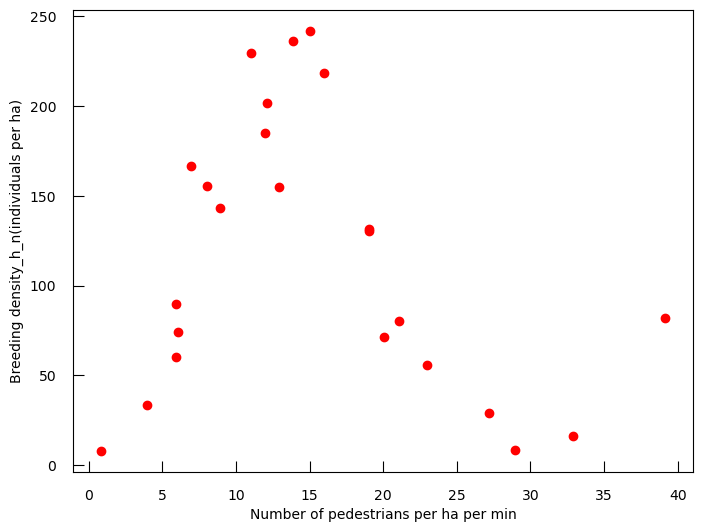

In [3]:
df_h_n = pd.read_csv("data/Human_nuisance.csv", index_col=0)
df_h_n.rename(
    columns={
        "Breeding density(individuals per ha)": "Breeding",
        "Number of pedestrians per ha per min": "N",
    },
    inplace=True,
)

fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(df_h_n.N, df_h_n.Breeding, "ro")
ax.set_ylabel("Breeding density_h_n(individuals per ha)")
ax.set_xlabel("Number of pedestrians per ha per min")
plt.show()

Let's get rid of the two last points. We could argue that they look fishy since they are the only two points that go up. Maybe they are driving the cubic fit?

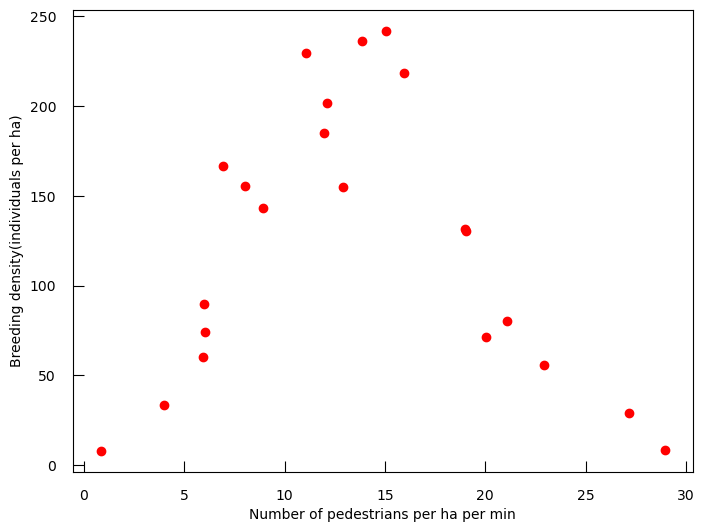

In [4]:
fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(df_h_n.N[:-2], df_h_n.Breeding[:-2], "ro")
ax.set_ylabel("Breeding density(individuals per ha)")
ax.set_xlabel("Number of pedestrians per ha per min")
plt.show()

In [5]:
list_co = []  # list of covariable


df_nuisance = df_h_n.copy()

models = []
logLikelihoods = []

for i in range(1, 5):
    df_nuisance["N" + str(i)] = df_nuisance.N**i

    list_co.append("N" + str(i))

    ## create the model, without the last 2 points
    model = smf.ols("Breeding ~ " + "+".join(list_co), data=df_nuisance.iloc[:-2, :])
    results = model.fit()  # we do the actual fit

    models.append("+".join(list_co))
    logLikelihoods.append(results.llf)

logLikelihoods

[-125.86306783486532,
 -112.64380299806211,
 -110.71030133123855,
 -103.39762229283637]

In [6]:
for i in range(1, len(logLikelihoods)):
    # calculating the pvalue for the LRT between the models
    pval = 1 - stats.chi2.cdf(2 * (logLikelihoods[i] - logLikelihoods[i - 1]), 1)

    print(
        "model {:<10} - model {:<12} : LRT p-value = {:.2e}".format(
            models[i - 1], models[i], pval
        )
    )


model N1         - model N1+N2        : LRT p-value = 2.72e-07
model N1+N2      - model N1+N2+N3     : LRT p-value = 4.92e-02
model N1+N2+N3   - model N1+N2+N3+N4  : LRT p-value = 1.31e-04


You see that the choice between quadratic and cubic is associated to a fairly high p-value here (~0.0492).

Let's check how the model behaves:

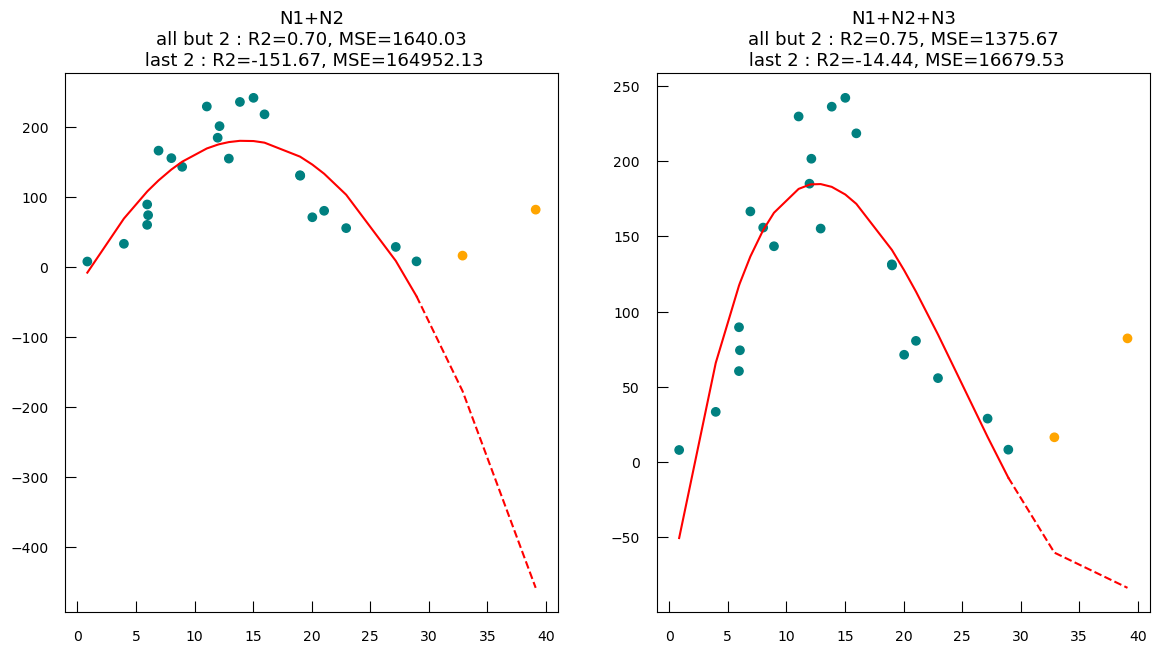

In [7]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

fig, ax = plt.subplots(1, 2, figsize=(14, 7))
## Quadratic model

for i, variables in enumerate(["N1+N2", "N1+N2+N3"]):
    model = smf.ols("Breeding ~ " + variables, data=df_nuisance.iloc[:-2])
    results = model.fit()  # we do the actual fit

    predicted = results.predict(df_nuisance)

    ## computing goodness of fit metrics
    R2_2_h_n = r2_score(df_nuisance.Breeding[:-2], predicted[:-2])
    MSE_2_h_n = mean_squared_error(df_nuisance.Breeding[:-2], predicted[:-2])

    R2_22_h_n = r2_score(df_nuisance.Breeding[-2:], predicted[-2:])
    MSE_22_h_n = mean_squared_error(df_nuisance.Breeding[-2:], predicted[-2:])

    ax[i].scatter(
        x=df_nuisance.N,
        y=df_nuisance.Breeding,
        c=["teal"] * (df_h_n.shape[0] - 2) + ["orange"] * 2,
    )
    ax[i].plot(df_nuisance.N[:-2], predicted[:-2], "r-")
    ax[i].plot(df_nuisance.N[-3:], predicted[-3:], "r--")

    ax[i].set_title(
        variables
        + "\nall but 2 : R2={0:.2f}, MSE={1:.2f}\n last 2 : R2={2:.2f}, MSE={3:.2f}".format(
            R2_2_h_n, MSE_2_h_n, R2_22_h_n, MSE_22_h_n
        ),
        fontsize=13,
    )

The cubic function is still overall better even on the points not used for the fitting (we actually kind of expected that).

<br>

[Back to the ToC](#toc)

<br>

## How does the model change according to random data subsamples. <a class="anchor" id="random-subsamples"></a>

We should check if this kind of behaviour where it becomes difficult to assert a good model is general or is it just because we decided to get rid of those two particular points. Let's check with more random subsamples and something a bit more balanced between number of points for fitting and for checking : here two is bit low.

Just for memory's sake, let's fit all the data as we did before

*Note : to run the code below you need to install pydotplus (!pip install pydotplus) if you don't have it already*

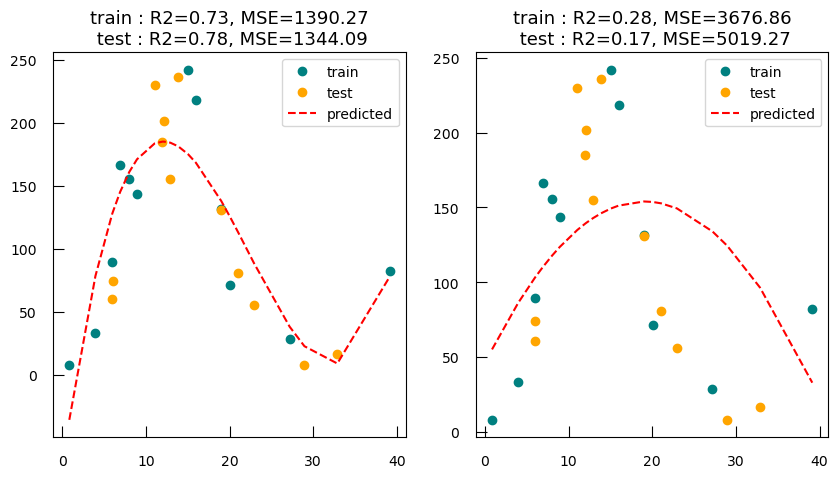

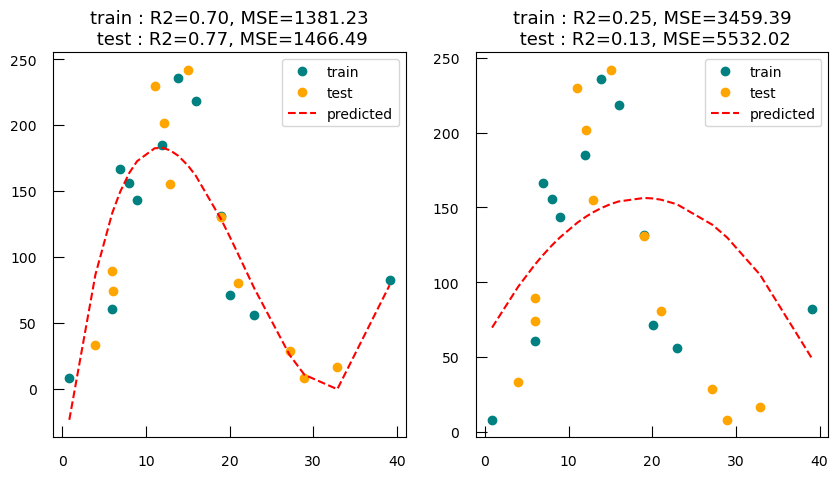

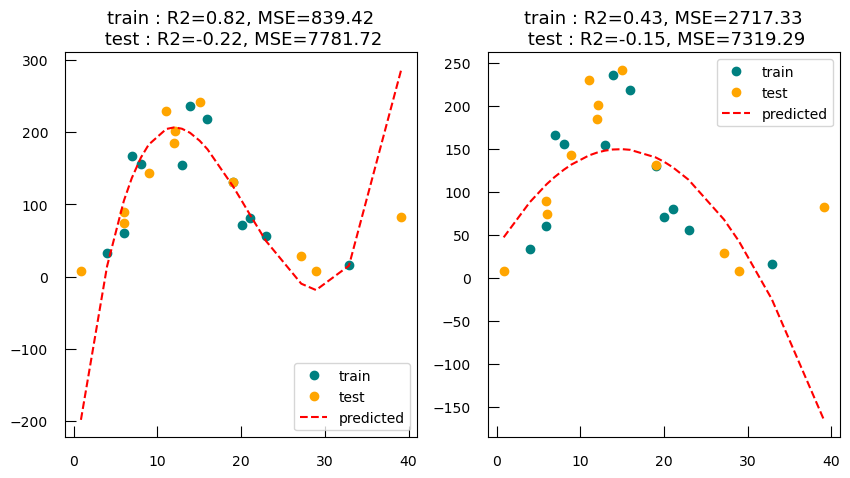

In [8]:
from utils import poly_fit_train_test

cubic = []
quadratic = []

## we reshape N to ake it compatible with the sklearn functions we use there
Nreshaped = np.array(df_nuisance.N).reshape(-1, 1)

for i in range(
    3
):  # here we are fitting our model and checking it on different random subsample of the data
    seed = np.random.randint(10**4)
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))

    cubic_metrics = poly_fit_train_test(
        Nreshaped, df_nuisance.Breeding, seed=seed, deg=3, ax=ax[0]
    )  # this contain the fit and some scoring metric
    quad_metrics = poly_fit_train_test(
        Nreshaped, df_nuisance.Breeding, seed=seed, deg=2, ax=ax[1]
    )

    cubic.append(cubic_metrics)
    quadratic.append(quad_metrics)

Let's see what the R2 are between cubic and quadratic for many splitting of the dataset and for known and unknown data points.

In [9]:
cubic = []
quadratic = []
for i in range(500):  # same as before but on way more different split
    temp3 = poly_fit_train_test(Nreshaped, df_nuisance.Breeding, deg=3, ax=None)
    temp2 = poly_fit_train_test(Nreshaped, df_nuisance.Breeding, deg=2, ax=None)

    if min(temp3) > 0 and min(temp2) > 0:
        cubic.append(temp3)
        quadratic.append(temp2)

In [10]:
cubic_known, cubic_new = list(zip(*cubic))
quadratic_known, quadratic_new = list(zip(*quadratic))

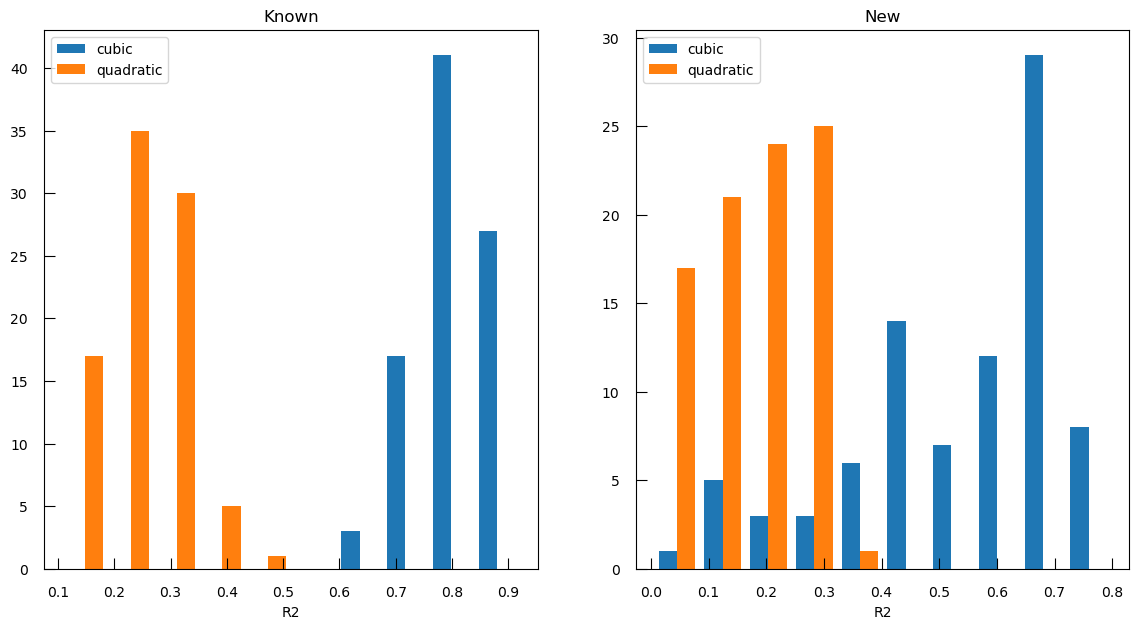

In [11]:
fig, ax = plt.subplots(1, 2, figsize=(14, 7))
ax[0].hist([cubic_known, quadratic_known], label=["cubic", "quadratic"])
ax[0].set_title("Known")
ax[0].legend(loc="best")
ax[0].set_xlabel("R2")

ax[1].hist([cubic_new, quadratic_new], label=["cubic", "quadratic"])
ax[1].set_title("New")
ax[1].legend(loc="best")
ax[1].set_xlabel("R2")
plt.show()

We see here that in most of those random cases the cubic model gives better prediction on the new data points. Yet all the outcome of those fitting are a bit different. How do we reconcile them?

<br>

[Back to the ToC](#toc)

<br>


## Splitting data and regularization. <a class="anchor" id="split-reg"></a>

**Maybe then, what you would like to do is to find the model that is best at predicting new data point whatever the specific data you fit on is.** You don't want to underfit neither overfit and start modeling the noise of your data. You need to find a compromize. You will sometime hear people use the terms bias variance problem or the **curse of dimensionality** when refering to that problem.

The approach used for that is a mix of what's called regularization, and splitting of your dataset. **Regularization**, as its name indicates has the ambition to smoothen your fit, to make sure that you don't start to fit the noise in your data so you can be as general in your prediction as possible.  It does that by putting another layer of constraints on your covariables (features). That constraint on your covariable translates in either the objective function you want to maximize/minimize (by adding a term in your least square or your maximum likelihood), or by constraining the space of available models.

Whatever that regularization is, its strength is always optimized by looking at subsamples of the dataset.

It is a nice automated method for model exploration, generalization and testing, which for me really defines machine learning. All of this is related to something called the curse of dimensionality. **And in any case, it relies on a splitting of your data set between at least a train and a test set**.

![presentation1](image/Presentation1.png)

You need the test set to assess the actual generalization of your model. **This test set should not be touched until the evaluation of your model.** Ideally by then you are looking at a model which is both good on the train and the test set.

You can imagine that it is the noise that makes the coefficient in front of the 149th polynomial look very important (so big), because here by construction we know that a fit with a polynomial greater than 3 is going to fit the noise. So you should penalize big coefficients unless they are absolutely necessary. Here necessary is to be understood as necessary for understanding all the subsamples of your data.

[Back to the ToC](#toc)

# Regularization in the case of OLS and GLM <a class="anchor" id="reg"></a>


In case of a Least Square fitting, you just have to add to your sum of squared errors a function that takes into account the parameters in front of your covariables. Looking at those equations you penalize weights that will take too much importance in the fitting, unless they are important in every substet of data that you fit on. We will see how those subsets are designed later on. By evaluating this new loss function on many subsets of the data we can perfom model comparison and choose model generalization, all at once. 

> Note : we report here the formulas used in `scikit-learn` functions. Other libraries may have a different parameterization, but the concepts stay the same

$\frac{1}{2n}\sum_i (y_i-f(\pmb X_i,\pmb{\beta}))^2 + \alpha\sum_{j}|\beta_{j}|$ , **l1 regularization** (Lasso) $\alpha$ being the weight that you put on that regularization 

$\sum_i (y_i-f(\pmb X_i,\pmb{\beta}))^2 + \alpha\sum_{j}\beta_{j}^{2}$ , **l2 regularization** (Ridge) 

$\frac{1}{2n}\sum_i (y_i-f(\pmb X_i,\pmb{\beta}))^2 + \alpha\sum_{j}(\rho|\beta_{j}|+\frac{(1-\rho)}{2}\beta_{j}^{2})$ , **elasticnet**


For a deeper understanding of those notions, you may look at :

 * https://www.datacamp.com/community/tutorials/tutorial-ridge-lasso-elastic-net

 * https://towardsdatascience.com/regularization-in-machine-learning-76441ddcf99a


In case of a logistic regression you want to maximize your log likelihood which is now penalized by one of those functions:

$\sum_{i}log(p_{i}) - \alpha\sum_{j}|\beta_{j}|$ , **l1 regularization** (Lasso) 

$\sum_{i}log(p_{i}) - \frac{\alpha}{2}\sum_{j}\beta_{j}^{2}$ , **l2 regularization** (Ridge) 

$\sum_{i}log(p_{i}) - \alpha\sum_{j}(\rho|\beta_{j}|+\frac{(1-\rho)}{2}\beta_{j}^{2})$ , **elasticnet**

Rule is : **when you hypothesize that you have sparse features and so you believe that among all those features only a small subset is going to be interesting (but of course you don't know which ones...) then you try to use the regularization that will tend to put more of your features at the zero weight (the l1 regularization) and so reduce the complexity of your model.** This l1 norm that collapses non-important features to zero is another way to do feature selection.


Now, we need a way to find this coefficient $\alpha$ which will set the strength of our regularization. This parameter is called an **hyperparameter**, and cannot be found directly like the others, since even if it is part of a new model it serve a generalization purpose and so should not be found by optimization on our full dataset. To do that on top of our first splitting between train dataset and test dataset, we will need to perfom some more splitting of our train data set.

> Note : the polynomial number we were using before is also an hyperparameter and can be find by the same technic consisting of splitting our data. Later on we will see other hyperparameters that are either related to model choice or regularization or intrically both.

Let's apply this on a couple of new datasets 

In [12]:
from sklearn.datasets import load_diabetes

diabetes = load_diabetes()

df_diabetes = pd.DataFrame(diabetes["data"], columns=diabetes["feature_names"])

df_diabetes.head()

age       sex       bmi        bp        s1        s2        s3  \
0  0.038076  0.050680  0.061696  0.021872 -0.044223 -0.034821 -0.043401   
1 -0.001882 -0.044642 -0.051474 -0.026328 -0.008449 -0.019163  0.074412   
2  0.085299  0.050680  0.044451 -0.005670 -0.045599 -0.034194 -0.032356   
3 -0.089063 -0.044642 -0.011595 -0.036656  0.012191  0.024991 -0.036038   
4  0.005383 -0.044642 -0.036385  0.021872  0.003935  0.015596  0.008142   

         s4        s5        s6  
0 -0.002592  0.019907 -0.017646  
1 -0.039493 -0.068332 -0.092204  
2 -0.002592  0.002861 -0.025930  
3  0.034309  0.022688 -0.009362  
4 -0.002592 -0.031988 -0.046641

In [13]:
%%time
from sklearn.linear_model import SGDRegressor
from sklearn.metrics import r2_score

# the SGDRegressor from sklearn
# uses gradient descent to find the best fit with the
# objective function modified with the regularization term

logalphas = []

coef_dict = {"name": [], "val": [], "log-alpha": []}
r2 = []

for alpha in np.logspace(-1, 1, 50):
    reg_diabetes = SGDRegressor(penalty="l1", alpha=alpha, max_iter=10000)
    reg_diabetes.fit(df_diabetes, diabetes["target"])

    logalphas.append(np.log10(alpha))
    r2.append(r2_score(diabetes["target"], reg_diabetes.predict(df_diabetes)))

    coef_dict["name"] += list(df_diabetes.columns)
    coef_dict["val"] += list(reg_diabetes.coef_)
    coef_dict["log-alpha"] += [np.log10(alpha)] * len(df_diabetes.columns)

coef_df = pd.DataFrame(coef_dict)

CPU times: user 11.2 s, sys: 9.38 ms, total: 11.2 s
Wall time: 11.2 s


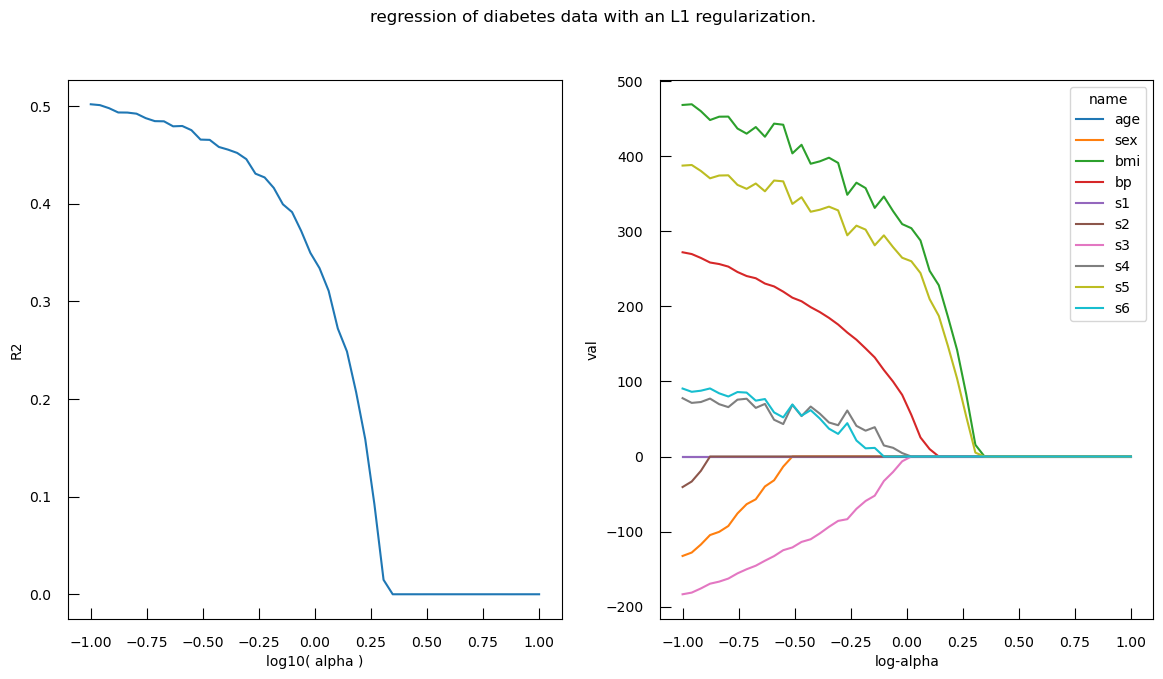

In [14]:
import seaborn as sns

fig, ax = plt.subplots(1, 2, figsize=(14, 7))

ax[0].plot(logalphas, r2)
ax[0].set_xlabel("log10( alpha )")
ax[0].set_ylabel("R2")

sns.lineplot(x="log-alpha", y="val", hue="name", data=coef_df, ax=ax[1])

fig.suptitle("regression of diabetes data with an L1 regularization.");

**Micro-exercise:** adapt the code above to generate this plot with an **l2** penalty. How do you interpret the difference?

This is great, but how do we choose which level of regularization we want ?

It is a general rule that **as you decrease $\alpha$, the $R^2$ on the data used for the fit increase**, i.e. you risk overfitting.

Consequently, we cannot choose the value of $\alpha$ parameter from the data used to fit alone; we call such a parameter an **hyper-parameter**.

**Question:** what are other hyper-parameters we could optimize at this point?

---

<br>

In order to find the optimal value of an hyper-parameter, we can separate our data into:
 * a **train set** : used to fit the model
 * a **validation set** : used to evaluate how our model perform on new data 
 
Here the $R^2$ stays fairly low even with little to no regularization, so overfitting is not that likely (I have checked, it is not).

Let's look at another data-set where overfitting is an issue.

[Acharjee et al.2016](https://bmcbioinformatics.biomedcentral.com/articles/10.1186/s12859-016-1043-4) propose several -omic dataset which they used to predict and gain knowledge on various phenotypic traits in potatos.

Here, we will concentrate on the their transcriptomics dataset and the phenotypic trait of the potato coloration.

We have pre-selected and normalized the 200 most promising genes (out of ~15 000).

In [15]:
df = pd.read_csv("data/potato_data.phenotypic.csv", index_col=0)
y = df["Flesh Colour"]
y.describe()

count    86.000000
mean     24.054824
std      13.023169
min       6.887500
25%      12.664600
50%      24.278800
75%      31.305050
max      57.035100
Name: Flesh Colour, dtype: float64

In [16]:
dfTT = pd.read_csv("data/potato_data.transcriptomic.top200norm.csv", index_col=0)
dfTT.head()

0         1         2         3         4         5  \
Genotype                                                               
CE017     0.086271 -0.790631 -0.445972  0.788895  0.510650  0.626438   
CE069    -0.540687  0.169014  0.282120 -1.107200 -1.200370  0.518986   
CE072    -1.713273 -1.400956 -1.543058 -0.930367 -1.058800 -0.455020   
CE084    -0.096239 -0.599251 -1.499636 -0.847275 -1.171365 -0.952574   
CE110    -0.712374 -1.081618 -1.530316 -1.259747 -1.109999 -0.582357   

                 6         7         8         9  ...       190       191  \
Genotype                                          ...                       
CE017     0.829346  0.432200 -1.344748  1.794652  ... -0.754008 -0.013125   
CE069     1.027663 -0.374142 -0.937715  1.488139  ... -0.237367  0.684905   
CE072    -1.302403 -0.110293 -0.332380 -0.232460  ... -0.131733 -0.070336   
CE084    -1.347691  0.561542 -0.335009 -0.702851  ... -0.729461  0.135614   
CE110    -1.233085  0.008014 -0.915632 -0.746339  ... -0.054882  0.363344   

               192       193       194       195       196       197  \
Genotype                                                               
CE017     0.852473  1.067286  0.877670  0.537247  1.251427  1.052070   
CE069     1.460319 -1.570253  0.547969  0.635307  0.257955  1.043724   
CE072     0.821996 -1.566652  0.914053 -1.707726  0.498226 -1.500588   
CE084     1.074398  0.629679 -0.691100 -1.247779  0.167965 -1.525064   
CE110     0.720155  0.465315  1.450199 -1.706606  0.602451 -1.507727   

               198       199  
Genotype                      
CE017    -0.135479 -0.526788  
CE069     0.733218 -1.768250  
CE072     0.361168 -1.020456  
CE084     0.150271  0.105746  
CE110    -2.207455 -0.139036  

[5 rows x 200 columns]

CPU times: user 15.8 s, sys: 13.2 s, total: 29 s
Wall time: 2.09 s


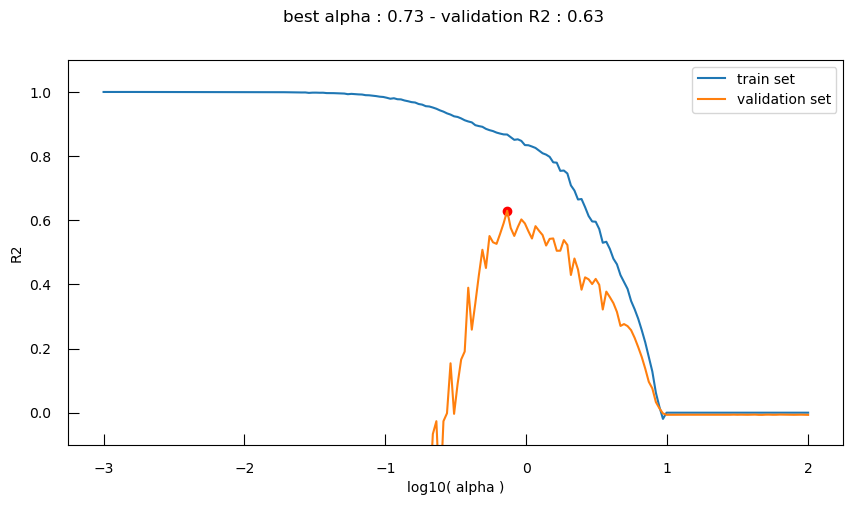

In [17]:
%%time
X = np.array(dfTT)

I = list(range(X.shape[0]))
np.random.shuffle(I)

# we will use the first 30 points to evaluate the model
X_valid = X[I[:30], :]
y_valid = y.iloc[I[:30]]

# we will use the rest to train the model
X_train = X[I[30:], :]
y_train = y.iloc[I[30:]]


logalphas = []

r2_train = []
r2_valid = []

for alpha in np.logspace(-3, 2, 200):
    reg_diabetes = SGDRegressor(penalty="l1", alpha=alpha, max_iter=2000)
    reg_diabetes.fit(X_train, y_train)

    logalphas.append(np.log10(alpha))
    r2_train.append(r2_score(y_train, reg_diabetes.predict(X_train)))
    r2_valid.append(r2_score(y_valid, reg_diabetes.predict(X_valid)))

## plotting and reporting
bestI = np.argmax(r2_valid)
bestLogAlpha = logalphas[bestI]
bestR2_valid = r2_valid[bestI]

fig, ax = plt.subplots(figsize=(10, 5))
fig.suptitle(
    "best alpha : {:.2f} - validation R2 : {:.2f}".format(
        10**bestLogAlpha, bestR2_valid
    )
)
ax.plot(logalphas, r2_train, label="train set")
ax.plot(logalphas, r2_valid, label="validation set")
ax.scatter([bestLogAlpha], [bestR2_valid], c="red")
ax.set_xlabel("log10( alpha )")
ax.set_ylabel("R2")
ax.set_ylim(-0.1, 1.1)
ax.legend();

So now, with the help of a validation set, we can clearly see the phases :
 * **underfitting** : for high $\alpha$, the performance is low for both the train and the validation set
 * **overfitting** : for low $\alpha$, the performance is high for the train set, and low for the validation set
 
We want the equilibrium point between the two where performance is ideal for the validation set.

**Problem :** if you run the code above several time, you will see that the optimal point varies due to the random assignation to train or validation set. 

There exists a myriad of possible strategies to deal with that problem, such as repeating the above many times and taking the average of the results for instance.
Note also that this problem gets less important as the validation set size increases.

<br>
---
<br>

So now, on top of our earlier regression model, we have added :

 * an **hyper-parameter** : $\alpha$, the strength of the regularization term
 * a **validation strategy** for our model in order to avoid overfitting

<br>

That's it, we are now in the world of Machine Learning.

<br>

[Back to the ToC](#toc)

<br>

# The machine learning framework <a class="anchor" id="ML-framework"></a>

Machine Learning, in a sense, is procuppied with the problem of **overfitting**, or how much model perform on new data.

To that end, we begin by dividing our data into :

 * **train** set : find the best model
 * **test** set  : give an honest evaluation of how the model perform on completely new data.

<!-- ![train_test](../images/train_test.png) -->
The train set will be used to find the best model, with the **best parameter and hyper-parameter values**.

The test set will only be used at the very end, to report model performance.


However, as we have seen the hyper-parameter cannot be set directly from the data that was used to train the model, thus, we deploy a **cross-validation strategy** by further splitting the train set.

For example, consider one of the most common strategy : **k-fold cross validation**


![k-fold validation](image/kfold.png)

In k-fold cross-validation, you split you data in $k$ subpart, called fold.

Then, for a given hyper-parameter values combination, you actually train $k$ model: each time you use a different fold for validation (and the remaining $k-1$ folds for training).

You then compute the average performance across all fold : this is the **cross-validated performance**.

If we code ourselves a naive version of this, it could look something like this:

In [18]:
## I make a helper function with tests a bunch for a given validation set of alpha values
def testAlphas(X_train, y_train, X_valid, y_valid, alphas):
    r2_valid = []

    for alpha in alphas:
        reg_diabetes = SGDRegressor(penalty="l1", alpha=alpha, max_iter=2000)
        reg_diabetes.fit(X_train, y_train)
        r2_valid.append(r2_score(y_valid, reg_diabetes.predict(X_valid)))

    return r2_valid


In [19]:
k = 4  ## 4-fold

## ugly initialization , we have to handle the fact that the number of sample is not perfectly divisible by 4
I = np.array(([0, 1, 2, 3] * ((X.shape[0] // k) + 1))[: X.shape[0]])

## shuffle randomly
np.random.shuffle(I)
print(I)

[0 2 0 0 2 3 3 2 3 1 0 1 2 2 3 1 3 1 0 2 0 0 2 0 1 0 1 2 3 3 0 2 1 1 1 2 0
 2 3 2 1 1 1 3 0 2 3 3 3 1 3 0 3 0 3 0 0 3 0 3 1 3 1 1 2 2 0 2 1 1 0 1 3 2
 0 3 3 2 0 1 1 2 2 2 1 0]


Text(0.5, 0.98, 'best alpha : 0.64 - cross-validated R2 : 0.59')

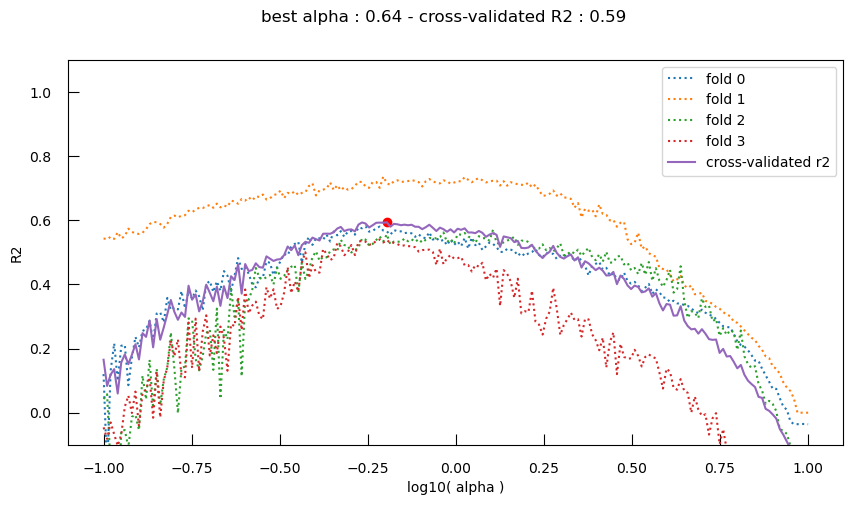

In [20]:
alphas = np.logspace(-1, 1, 200)

cumulated_r2 = np.zeros(alphas.shape)


fig, ax = plt.subplots(figsize=(10, 5))


for fold in range(k):
    X_valid = X[I == fold, :]
    y_valid = y[I == fold]

    # we will use the rest to train the model
    X_train = X[I != fold, :]
    y_train = y[I != fold]

    r2 = testAlphas(X_train, y_train, X_valid, y_valid, alphas)
    cumulated_r2 += r2

    ax.plot(np.log10(alphas), r2, label="fold " + str(fold), linestyle="dotted")

## cross-validated r2 is the average across each fold:
cross_valid_r2 = cumulated_r2 / k

bestI = np.argmax(cross_valid_r2)
bestLogAlpha = np.log10(alphas[bestI])
bestR2_valid = cross_valid_r2[bestI]

ax.plot(np.log10(alphas), cross_valid_r2, label="cross-validated r2")
ax.scatter([bestLogAlpha], [bestR2_valid], c="red")
ax.set_xlabel("log10( alpha )")
ax.set_ylabel("R2")
ax.set_ylim(-0.1, 1.1)
ax.legend()

fig.suptitle(
    "best alpha : {:.2f} - cross-validated R2 : {:.2f}".format(
        10**bestLogAlpha, bestR2_valid
    )
)

There, you can realize that now, for each possible value of our hyper-parameter we fit and evaluate not 1, but $k$ models, here 4.

So, for 200 values of $\alpha$, that means 200x4 = 800 models to fit and evaluate.

Now, consider that we have other hyper-parameters, such as the type of regularization (L1 or L2),
or the degree of the polynomial we consider, and now you understand why Machine Learning can quickly become  computationnaly intensive. 

---

Finally, here is the proposed strategy as aschematic, just to reiterate

![presentation2](image/Presentation2.png)

For those kind of methods to work, since we are solicitting our dataset many times, you need to have quite a lot of points. Typically the number of points for our sparrow disturbance is too small to perform nicely this procedure. 


<br>

[Back to the ToC](#toc)

<br>

# OLS and GLM regression with the classical ML pipeline <a class="anchor" id="lr-ols"></a>

## classical ML pipeline OLS regression <a class="anchor" id="lr-ols-pipeline"></a>

Let's come back to the diabetes dataset:

In [21]:
df_diabetes.head()

age       sex       bmi        bp        s1        s2        s3  \
0  0.038076  0.050680  0.061696  0.021872 -0.044223 -0.034821 -0.043401   
1 -0.001882 -0.044642 -0.051474 -0.026328 -0.008449 -0.019163  0.074412   
2  0.085299  0.050680  0.044451 -0.005670 -0.045599 -0.034194 -0.032356   
3 -0.089063 -0.044642 -0.011595 -0.036656  0.012191  0.024991 -0.036038   
4  0.005383 -0.044642 -0.036385  0.021872  0.003935  0.015596  0.008142   

         s4        s5        s6  
0 -0.002592  0.019907 -0.017646  
1 -0.039493 -0.068332 -0.092204  
2 -0.002592  0.002861 -0.025930  
3  0.034309  0.022688 -0.009362  
4 -0.002592 -0.031988 -0.046641

In [22]:
diabetes["target"][:5]

array([151.,  75., 141., 206., 135.])

In [23]:
from sklearn.model_selection import train_test_split

# always split your dataset and do the fitting on the training
# the train_test_split will split the data into train and test set
# let's keep 25% of the data aside for the final test
X_diabetes_train, X_diabetes_test, y_diabetes_train, y_diabetes_test = train_test_split(
    df_diabetes, diabetes["target"], test_size=0.25, random_state=1425
)
print("train set size", len(y_diabetes_train))
print("test  set size", len(y_diabetes_test))

train set size 331
test  set size 111


In [24]:
%%time
from sklearn.linear_model import SGDRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

# while not strictly necessary for this dataset,
# regression model normally need the X values to be properly scaled.
# this is something that was done under the hood by statsmodels, but with sklearn
# we have to handle it explicitely.
#
# NB : in that particular dataset the data is already scaled,
#      but we wanted to show this important step anyway

# in our model we will also consider polynomials for our features,
# the PolynomialFeatures object generates all polynomials of a given degree for us


pipeline_reg_diabetes = Pipeline(
    [
        ("scalar", StandardScaler()),
        ("poly", PolynomialFeatures(include_bias=False)),
        ("model", SGDRegressor()),
    ]
)


# define the hyperparameters you want to test
# with the range over which you want it to be tested.
# Here the hyperparamters
#   * the degree of the polynomials
#   * the form of regularization : l1 or l2
#   * the strength of regularization : alpha
grid_values = {
    "poly__degree": np.arange(1, 4, 1),
    "model__penalty": ["l1", "l2"],
    "model__alpha": np.logspace(-1, 1, 100),
}


# Feed the pipeline and set of values to the GridSearchCV with the
# score over which the decision should be taken (ir R^2).
# and the cross-validation scheme, here the number of fold in a stratified k-fold strategy
grid_reg_diabetes_r2 = GridSearchCV(
    pipeline_reg_diabetes, param_grid=grid_values, scoring="r2", cv=5, n_jobs=-1
)

# Where the actual fit happens
#  the gridSearchCV object will go through each hyperparameter value combination
#  and fit + evaluate each fold, and averages the score across each fold
#
#  it then finds the combination that gave the best score and
#  use it to re-train a model with the whole train data
grid_reg_diabetes_r2.fit(X_diabetes_train, y_diabetes_train)

# get the best cross-validated score
print(
    "Grid best score (" + grid_reg_diabetes_r2.scoring + "): ",
    grid_reg_diabetes_r2.best_score_,
)
# print the best parameters
print("Grid best parameter :")
for k, v in grid_reg_diabetes_r2.best_params_.items():
    print(" {:>20} : {}".format(k, v))


Grid best score (r2):  0.4853310509188523
Grid best parameter :
         model__alpha : 3.1257158496882367
       model__penalty : l1
         poly__degree : 2
CPU times: user 7.12 s, sys: 2.63 s, total: 9.75 s
Wall time: 28.5 s


In [25]:
# get the equivalent score on the test set
y_diabetes_decision_fn_scores_r2 = grid_reg_diabetes_r2.score(
    X_diabetes_test, y_diabetes_test
)

print(
    "Grid best parameter (max. " + grid_reg_diabetes_r2.scoring + ") model on test: ",
    y_diabetes_decision_fn_scores_r2,
)

Grid best parameter (max. r2) model on test:  0.47522614632856475


One can also access the best model parameter:

In [27]:
# here is a recipe to get the name of the features, with their power

best_reg = grid_reg_diabetes_r2.best_estimator_["model"]
poly = grid_reg_diabetes_r2.best_estimator_["poly"]

# TODO: simplify logic
coef_names = [
    "_".join(
        [
            df_diabetes.columns[j] + "^" + str(poly.powers_[i][j])
            for j in range(len(df_diabetes.columns))
            if poly.powers_[i][j] > 0
        ]
    )
    for i in range(len(poly.powers_))
]

sorted_features = sorted(
    [(coef_names[i], abs(best_reg.coef_[i])) for i in range(len(poly.powers_))],
    key=itemgetter(1),
    reverse=True,
)

print("Important features")

for feature, weight in sorted_features:
    print("\t{:>10}\t{:.3f}".format(feature, weight))

Important features
	     sex^2	46.196
	     bmi^1	23.369
	      s5^1	22.877
	      bp^1	10.818
	      s3^1	7.647
	age^1_sex^1	5.651
	     sex^1	5.537
	     bmi^2	4.758
	      bp^2	4.327
	      s6^2	4.035
	     age^2	3.220
	bmi^1_bp^1	1.959
	      s1^2	1.561
	sex^1_s2^1	1.317
	      s4^1	0.795
	sex^1_s1^1	0.498
	     age^1	0.055
	      s1^1	0.000
	      s2^1	0.000
	      s6^1	0.000
	age^1_bmi^1	0.000
	age^1_bp^1	0.000
	age^1_s1^1	0.000
	age^1_s2^1	0.000
	age^1_s3^1	0.000
	age^1_s4^1	0.000
	age^1_s5^1	0.000
	age^1_s6^1	0.000
	sex^1_bmi^1	0.000
	sex^1_bp^1	0.000
	sex^1_s3^1	0.000
	sex^1_s4^1	0.000
	sex^1_s5^1	0.000
	sex^1_s6^1	0.000
	bmi^1_s1^1	0.000
	bmi^1_s2^1	0.000
	bmi^1_s3^1	0.000
	bmi^1_s4^1	0.000
	bmi^1_s5^1	0.000
	bmi^1_s6^1	0.000
	 bp^1_s1^1	0.000
	 bp^1_s2^1	0.000
	 bp^1_s3^1	0.000
	 bp^1_s4^1	0.000
	 bp^1_s5^1	0.000
	 bp^1_s6^1	0.000
	 s1^1_s2^1	0.000
	 s1^1_s3^1	0.000
	 s1^1_s4^1	0.000
	 s1^1_s5^1	0.000
	 s1^1_s6^1	0.000
	      s2^2	0.000
	 s2^1_s3^1	0.000
	 s2^1_s4^1	0.000
	 

And we can plot the model prediction against the data:

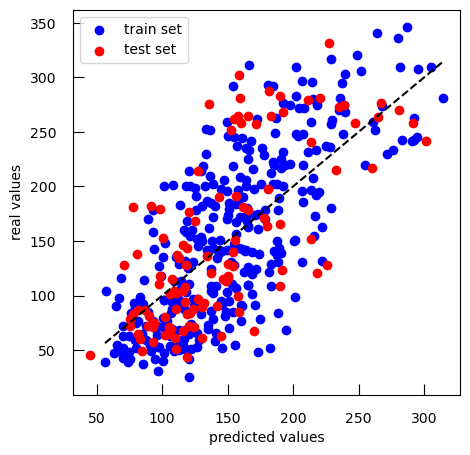

In [28]:
## train prediction
y_diabetes_train_pred = grid_reg_diabetes_r2.predict(X_diabetes_train)
## test prediction
y_diabetes_test_pred = grid_reg_diabetes_r2.predict(X_diabetes_test)


plt.scatter(y_diabetes_train_pred, y_diabetes_train, c="blue", label="train set")
plt.scatter(y_diabetes_test_pred, y_diabetes_test, c="red", label="test set")
m, M = min(y_diabetes_train_pred), max(y_diabetes_train_pred)
plt.plot([m, M], [m, M], "k--")
plt.xlabel("predicted values")
plt.ylabel("real values")
plt.legend()

In [29]:
grid_reg_diabetes_r2.best_estimator_["scalar"]

StandardScaler()

[back to ToC](#toc)

## A toy model to visualize logistic regression. <a class="anchor" id="toy-example-lr"></a>

Let's imagine a simple case with 2 groups, and a single feature:

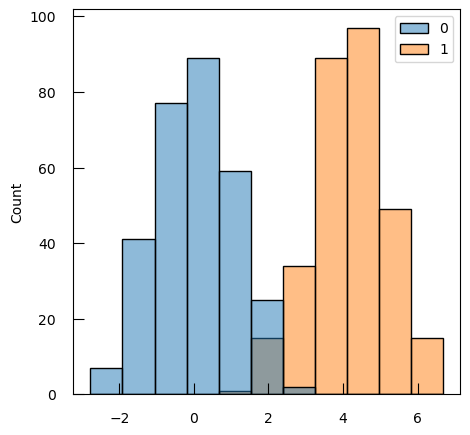

In [31]:
X1 = np.concatenate([np.random.randn(300), np.random.randn(300) + 4])
y = np.array([0] * 300 + [1] * 300)

sns.histplot(x=X1, hue=y);

We will use a logistic regression to model the relationship between the class and the feature.

Remember : **Logistic regression does not model the class directly, but rather model the class probabilities** (through the logit transform)

Let's see how regularization affect the class probabilities found by our model:

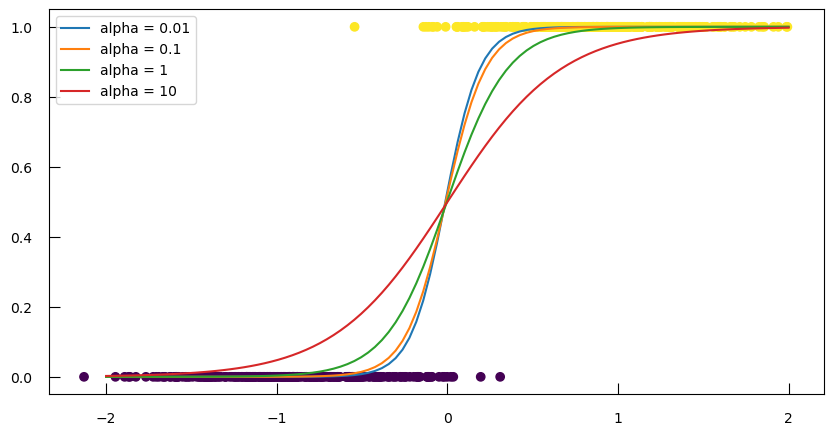

In [33]:
from sklearn.linear_model import LogisticRegression

# do not forget to scale the data
X1_norm = StandardScaler().fit_transform(X1.reshape(X1.shape[0], 1))

fig, ax = plt.subplots(figsize=(10, 5))

ax.scatter(X1_norm, y, c=y)

for alpha in [0.01, 0.1, 1, 10]:
    # this implementation does not take alpha but rather C = 1/alpha
    C = 1 / alpha
    lr = LogisticRegression(penalty="l2", C=C)
    lr.fit(X1_norm, y)

    proba = lr.predict_proba(np.linspace(-2, 2, 100).reshape(-1, 1))
    ax.plot(np.linspace(-2, 2, 100), proba[:, 1], label="alpha = {}".format(alpha))
ax.legend();

We can see that **when $\alpha$ grows the probabilities evolve more smoothly** ie. we have more regularization.

> However, note that all the curves meet at the same point, corresponding to the 0.5 probability.

This is nice, but **our end-goal is to actually be able to predict the classes**, and not just the probabilities.

Our task is not regression anymore, but rather **classification**.

So here, we do not evaluate the model using $R^2$ or log-likelihood, but a classification metric.

we will discuss a few of these metrics, and we will begin by the most common: **Accuracy**


The Accuracy is the proportion of samples which were correctly classified (as either category).

More mathematically:

$$Accuracy = \frac{TP + TN}{TP+FP+FN+TN}$$

![image/TPFP.png](image/TPFP.png)
Image credit wikipedia user Sharpr for svg version. original work by kakau in a png. Licensed under the [Creative Commons Attribution-Share Alike 3.0 Unported license](https://creativecommons.org/licenses/by-sa/3.0/deed.en).

* TP : True Positive
* FP : False Positive
* TN : True Negative
* FN : False Negative

So you can see that accuracy forces us to make a choice about the **probability threshold we use predict categories**.

0.5 is a common choice, and the default of the `predict` method:


In [34]:
from sklearn.metrics import accuracy_score

y_predicted = lr.predict(X1_norm)

print(f"Accuracy with a threshold of 0.5 : {accuracy_score(y,y_predicted):.2f}")

pd.crosstab(y, y_predicted)

Accuracy with a threshold of 0.5 : 0.98


col_0    0    1
row_0          
0      296    4
1        8  292

But it can be useful to remember that this is only 1 choice among many:

In [36]:
threshold = 0.2
y_predicted = lr.predict_proba(X1_norm)[:, 1] > threshold
print(f"Accuracy with a threshold of {threshold} : {accuracy_score(y,y_predicted):.2f}")
pd.crosstab(y, y_predicted)

Accuracy with a threshold of 0.2 : 0.92


col_0  False  True 
row_0              
0        250     50
1          1    299

**Micro-exercise :** modify the threhold in the code above. 
 * in which direction should the threshold move to limit the number of False Positive ?
 * for which application could that be useful ? 


[Back to ToC](#toc)

## classical ML pipeline logistic regression <a class="anchor" id="lr-pipeline"></a>

Let's build a logistic regression model that will be able to predict if a breast tumor is malignant or not

In [38]:
from sklearn.datasets import load_breast_cancer

# loading the dataset which is comprised in scikit learn already
data = load_breast_cancer()

## we reduce the features because otherwise this problem is a bit too easy ;-)
m = list(map(lambda x: x.startswith("mean "), data["feature_names"]))


X_cancer = data["data"][:, m]
y_cancer = 1 - data["target"]

# making it into a dataframe
breast_cancer_df = pd.DataFrame(X_cancer, columns=data["feature_names"][m])

breast_cancer_df["target"] = y_cancer

breast_cancer_df.head()

mean radius  mean texture  mean perimeter  mean area  mean smoothness  \
0        17.99         10.38          122.80     1001.0          0.11840   
1        20.57         17.77          132.90     1326.0          0.08474   
2        19.69         21.25          130.00     1203.0          0.10960   
3        11.42         20.38           77.58      386.1          0.14250   
4        20.29         14.34          135.10     1297.0          0.10030   

   mean compactness  mean concavity  mean concave points  mean symmetry  \
0           0.27760          0.3001              0.14710         0.2419   
1           0.07864          0.0869              0.07017         0.1812   
2           0.15990          0.1974              0.12790         0.2069   
3           0.28390          0.2414              0.10520         0.2597   
4           0.13280          0.1980              0.10430         0.1809   

   mean fractal dimension  target  
0                 0.07871       1  
1                 0.05667       1  
2                 0.05999       1  
3                 0.09744       1  
4                 0.05883       1

In [39]:
breast_cancer_df.target.value_counts()

target
0    357
1    212
Name: count, dtype: int64

* 357 benign samples
* 212 malignant samples

Here, all these covariables / features are defined on very different scales, for them to be treated fairly in their comparison you need to take that into account by scaling.

But first, let's split the model into a train and a test dataset:

In [42]:
# split your data

# stratify is here to make sure that you split keeping the repartition of labels unaffected
X_train_cancer, X_test_cancer, y_train_cancer, y_test_cancer = train_test_split(
    X_cancer, y_cancer, random_state=0, stratify=y_cancer
)


print("fraction of class malignant in train", sum(y_train_cancer) / len(y_train_cancer))
print("fraction of class malignant in test ", sum(y_test_cancer) / len(y_test_cancer))
print("fraction of class malignant in full ", sum(y_cancer) / len(y_cancer))

fraction of class malignant in train 0.3732394366197183
fraction of class malignant in test  0.3706293706293706
fraction of class malignant in full  0.37258347978910367


In [43]:
%%time
## create the pipeline of data handling :
## scaling, then logistic regression

## in order for the LogisticRegression object takes solver="liblinear" argument
## in order to be able to test the l1 and l2 norm
## other solver exists, and are more or less performant / have different capabilities
pipeline_lr_cancer = Pipeline(
    [("scaler", StandardScaler()), ("model", LogisticRegression(solver="liblinear"))]
)

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report

grid_values = {"model__C": np.logspace(-5, 2, 100), "model__penalty": ["l1", "l2"]}

grid_lr_cancer_acc = GridSearchCV(
    pipeline_lr_cancer, param_grid=grid_values, scoring="accuracy", cv=5, n_jobs=-1
)

grid_lr_cancer_acc.fit(X_train_cancer, y_train_cancer)  # train your pipeline

# get the best cross-validated score
print(
    "Grid best score (" + grid_lr_cancer_acc.scoring + "): ",
    grid_lr_cancer_acc.best_score_,
)
# print the best parameters
print("Grid best parameter :")
for k, v in grid_lr_cancer_acc.best_params_.items():
    print(" {:>20} : {}".format(k, v))

Grid best score (accuracy):  0.9436935704514363
Grid best parameter :
             model__C : 0.021049041445120195
       model__penalty : l2
CPU times: user 808 ms, sys: 61.4 ms, total: 869 ms
Wall time: 847 ms


In [44]:
1 / 0.02

50.0

In [46]:
# calculate the score of your trained pipeline on the test
cancer_acc = grid_lr_cancer_acc.score(X_test_cancer, y_test_cancer)
print(
    "Grid best parameter (max." + grid_lr_cancer_acc.scoring + ") model on test: ",
    cancer_acc,
)

Grid best parameter (max.accuracy) model on test:  0.9370629370629371


In [47]:
y_test_cancer.shape

(143,)

In [50]:
# we can then access the coefficient of the model, to assess the importance of the different parameters:

w_lr_cancer = grid_lr_cancer_acc.best_estimator_["model"].coef_[0]

sorted_features = sorted(
    zip(breast_cancer_df.columns, np.abs(w_lr_cancer)), key=itemgetter(1), reverse=True
)

print("Features sorted per importance in discriminative process")
for f, ww in sorted_features:
    print("{:>25}\t{:.3f}".format(f, ww))

Features sorted per importance in discriminative process
      mean concave points	0.497
              mean radius	0.442
           mean perimeter	0.441
                mean area	0.422
           mean concavity	0.399
             mean texture	0.373
         mean compactness	0.295
          mean smoothness	0.264
            mean symmetry	0.183
   mean fractal dimension	0.070


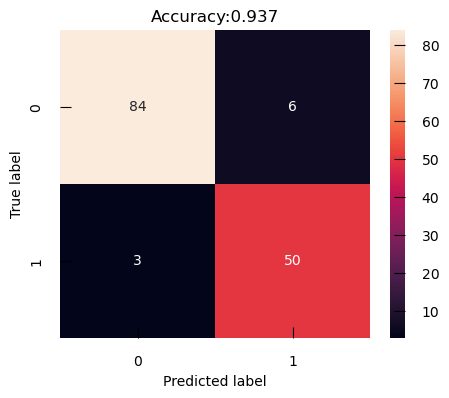

In [52]:
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns


y_cancer_test_pred = grid_lr_cancer_acc.predict(X_test_cancer)

# get the confusion matrix:
confusion_m_cancer = confusion_matrix(y_test_cancer, y_cancer_test_pred)

## recipe to plot the confusion matrix :
plt.figure(figsize=(5, 4))
sns.heatmap(confusion_m_cancer, annot=True)
plt.title("Accuracy:{0:.3f}".format(accuracy_score(y_test_cancer, y_cancer_test_pred)))
plt.ylabel("True label")
plt.xlabel("Predicted label");

So, with its default threshold of 0.5, this model tends to produce more False Positive (ie. benign cancer seen as malignant), than False Negative (ie. malignant cancer seen as benign).

Depending on the particular of the problem we are trying to solve, that may be a desirable outcome.

Whatever the case, it is always interesting to explore a bit more : we will plot how each possible threshold affect the True Positive Rate and the False Positive Rate (**TPR and FPR**) : this is the Receiver Operating Characteristic c urve (**ROC curve**)

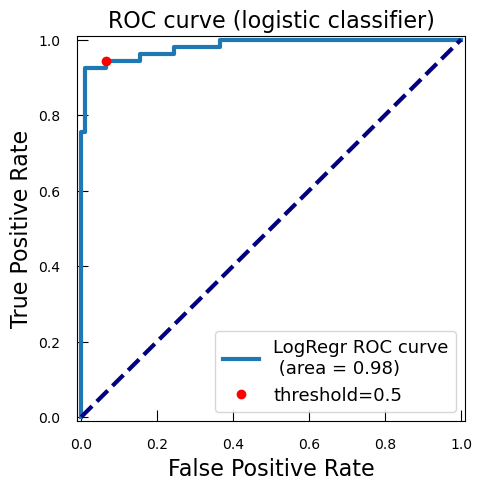

In [53]:
from scipy.special import expit
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

# 1. the decision_function gives you the "score" for a point to be in a class
y_score_lr_cancer = grid_lr_cancer_acc.decision_function(X_test_cancer)

#   for the logistic regression, that score is the logit, so can convert it back to
#   probabilities with the expit function (which is the inverse of the logit)
y_proba_lr_cancer = expit(y_score_lr_cancer)

# 2. this calculates the ROC curve : TPR and FPR for each threshold of score
fpr_lr_cancer, tpr_lr_cancer, threshold_cancer = roc_curve(
    y_test_cancer, y_proba_lr_cancer
)

# we find the point corresponding to a 0.5 theshold
keep = np.argmin(np.abs(threshold_cancer - 0.5))

# we compute the area under the ROC curve
roc_auc_lr_cancer = auc(fpr_lr_cancer, tpr_lr_cancer)

# 3. plotting
plt.figure()
plt.xlim([-0.01, 1.01])
plt.ylim([-0.01, 1.01])
plt.plot(
    fpr_lr_cancer,
    tpr_lr_cancer,
    lw=3,
    label="LogRegr ROC curve\n (area = {:0.2f})".format(roc_auc_lr_cancer),
)
plt.plot(fpr_lr_cancer[keep], tpr_lr_cancer[keep], "ro", label="threshold=0.5")
plt.xlabel("False Positive Rate", fontsize=16)
plt.ylabel("True Positive Rate", fontsize=16)
plt.title("ROC curve (logistic classifier)", fontsize=16)
plt.legend(loc="lower right", fontsize=13)
plt.plot([0, 1], [0, 1], color="navy", lw=3, linestyle="--")
plt.show()

So with this ROC curve, we can see how the model would behave on different thresholds.

**Question:** we have marked the 0.5 threshold on the plot. Where would a higher threshold be on the curve?

<br>

---

You can see that when plotting the ROC curve, I have also computed its "Area Under the Curve" : 
indeed ROC AUC is another common metric when doing classification.


For now, let's put this aside briefly to explore a very common problem in classification : imbalance

<br>

[Back to the ToC](#toc)

<br>

## Imbalanced dataset <a class="anchor" id="imbalanced"></a> 

Let's use the same small example as before, but now instead of 300 sample of each class, imagine we only have 30 of class 1:

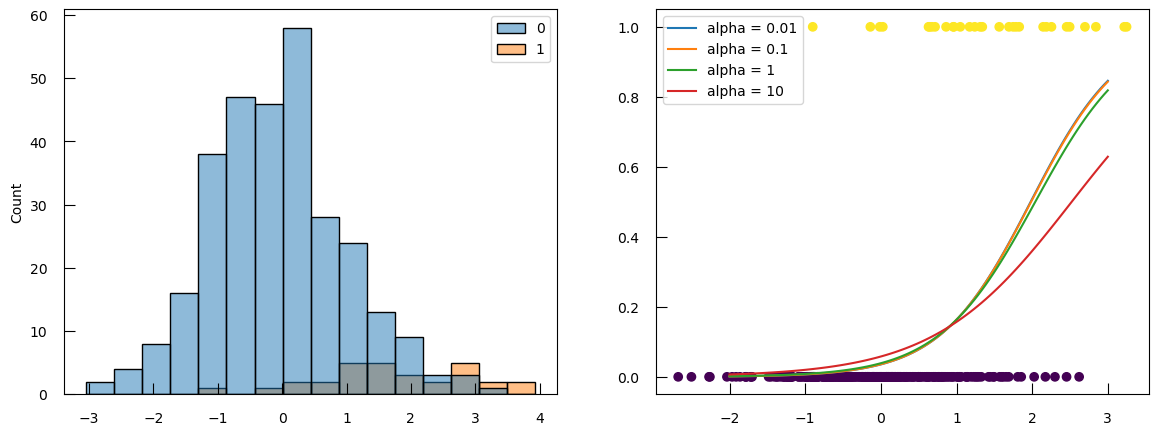

In [54]:
X1 = np.concatenate([np.random.randn(300), np.random.randn(30) + 2])
y = np.array([0] * 300 + [1] * 30)

# do not forget to scale the data
X1_norm = StandardScaler().fit_transform(X1.reshape(X1.shape[0], 1))

fig, ax = plt.subplots(1, 2, figsize=(14, 5))

sns.histplot(x=X1, hue=y, ax=ax[0])


ax[1].scatter(X1_norm, y, c=y)

for alpha in [0.01, 0.1, 1, 10]:
    # this implementation does not take alpham but rather C = 1/alpha
    C = 1 / alpha
    lr = LogisticRegression(penalty="l2", C=C)
    lr.fit(X1_norm, y)

    proba = lr.predict_proba(np.linspace(-2, 3, 100).reshape(-1, 1))
    ax[1].plot(np.linspace(-2, 3, 100), proba[:, 1], label="alpha = {}".format(alpha))
ax[1].legend();

You can see that now the point where the probability curves for different alpha converge is not 0.5 anymore...

Also, the probability says fairly low even at the right end of the plot.

In [50]:
y_predicted = lr.predict(X1_norm)
print(f"Accuracy with a threshold of 0.5 : {accuracy_score(y,y_predicted):.2f}")
pd.crosstab(y, y_predicted)

Accuracy with a threshold of 0.5 : 0.92


col_0    0  1
row_0        
0      298  2
1       25  5

So, most of the class 1 samples are miss-classified (22/30), but we still get a very high accuracy...

That is because, by contruction, both the **logistic regression and accuracy score do not differentiate False Positive and False Negative**.

And the problem gets worse the more imbalance there is :

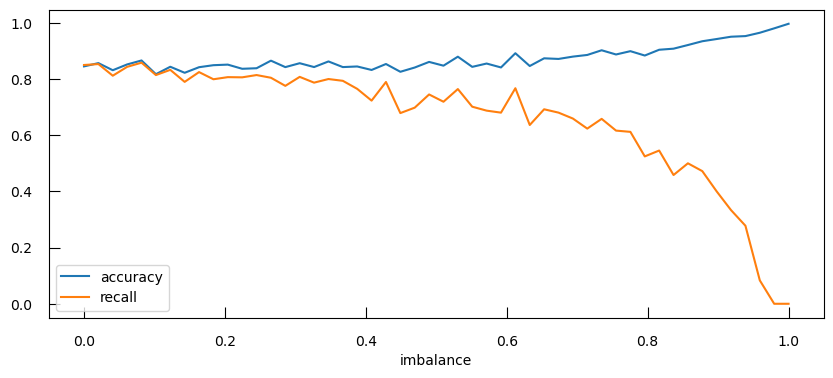

In [55]:
from sklearn.metrics import recall_score

## RECALL = TP / (TP + FN)

recall_list = []
acc_list = []

imbalance_list = np.linspace(0, 1, 50)

alpha = 1
for imbalance in imbalance_list:
    n0 = 300
    n1 = int(n0 * (1 - imbalance))
    if n1 == 0:
        n1 = 1

    X1 = np.concatenate([np.random.randn(n0), np.random.randn(n1) + 2])
    y = np.array([0] * n0 + [1] * n1)

    X1_norm = StandardScaler().fit_transform(X1.reshape(X1.shape[0], 1))

    C = 1 / alpha
    lr = LogisticRegression(penalty="l2", C=C)
    lr.fit(X1_norm, y)

    y_predicted = lr.predict(X1_norm)

    recall_list.append(recall_score(y, y_predicted))
    acc_list.append(accuracy_score(y, y_predicted))


fig, ax = plt.subplots(figsize=(10, 4))
ax.plot(imbalance_list, acc_list, label="accuracy")
ax.plot(imbalance_list, recall_list, label="recall")
ax.set_xlabel("imbalance")
ax.legend();

So not only does the precision get worse, the **accuracy actually gets higher as there is more imbalance!**

So the problem here may be 2-fold:
 * imbalance in our dataset skews the **logistic regression** toward a particular outcome
 * **accuracy** is not able to differenciate between False Positive and False Negative, and so it is **blind to imbalance**

Consequently, the solutions will have to come both from the model, and from the metric we are using.


**For the logistic regression**:
 * we will re-weight sample according to their class frequency, so that they are more important during the fitting.
 * in sklearn : `LogisticRegression( ... , class_weight='balanced')`
 
<br> 

**For the metric**, there exists several metrics which are sensitive to imbalance problems. 
Here we will introduce the **[balanced accuracy](https://scikit-learn.org/stable/modules/model_evaluation.html#balanced-accuracy-score)**:

$$balanced\_accuracy = 0.5*( \frac{TP}{TP+FN} + \frac{TN}{TN+FP} )$$

> Other scores you may want to look-up : [average-precision score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.average_precision_score.html#sklearn.metrics.average_precision_score), and [f1-score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html#sklearn.metrics.f1_score), which are both linked to the precision/recall curve


In [56]:
from sklearn.metrics import balanced_accuracy_score


def check_imbalance_effect(imbalance_list, class_weight=None):
    recall_list = []
    balanced_acc_list = []
    acc_list = []
    for imbalance in imbalance_list:
        n0 = 300
        n1 = int(n0 * (1 - imbalance))
        if n1 == 0:
            n1 = 1

        X1 = np.concatenate([np.random.randn(n0), np.random.randn(n1) + 2])
        y = np.array([0] * n0 + [1] * n1)

        X1_norm = StandardScaler().fit_transform(X1.reshape(X1.shape[0], 1))

        # LR
        lr = LogisticRegression(penalty="l2", C=1, class_weight=class_weight)
        lr.fit(X1_norm, y)

        y_predicted = lr.predict(X1_norm)

        recall_list.append(recall_score(y, y_predicted))
        acc_list.append(accuracy_score(y, y_predicted))
        balanced_acc_list.append(balanced_accuracy_score(y, y_predicted))

    return recall_list, acc_list, balanced_acc_list

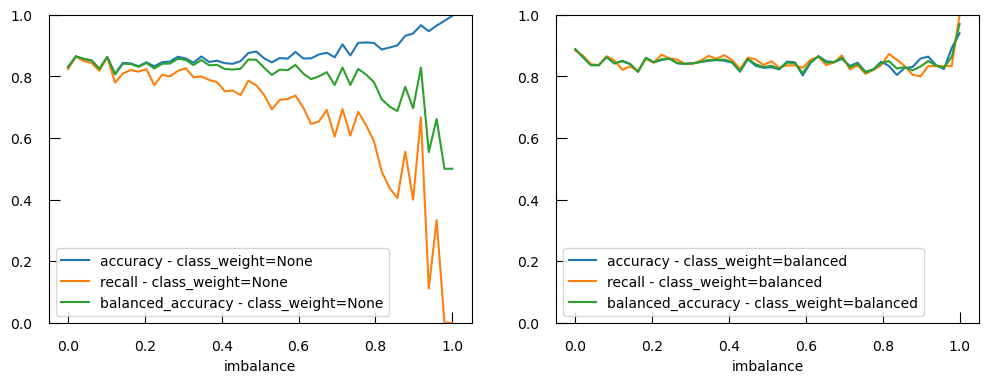

In [57]:
imbalance_list = np.linspace(0, 1, 50)

### first, we see what happens without class_weight=None

recall_list, acc_list, balanced_acc_list = check_imbalance_effect(
    imbalance_list, class_weight=None
)


fig, ax = plt.subplots(1, 2, figsize=(12, 4))
ax[0].plot(imbalance_list, acc_list, label="accuracy - class_weight=None")
ax[0].plot(imbalance_list, recall_list, label="recall - class_weight=None")
ax[0].plot(
    imbalance_list, balanced_acc_list, label="balanced_accuracy - class_weight=None"
)
ax[0].set_xlabel("imbalance")
ax[0].set_ylim(0, 1)
ax[0].legend()
## now, with class weight

recall_list, acc_list, balanced_acc_list = check_imbalance_effect(
    imbalance_list, class_weight="balanced"
)

ax[1].plot(imbalance_list, acc_list, label="accuracy - class_weight=balanced")
ax[1].plot(imbalance_list, recall_list, label="recall - class_weight=balanced")
ax[1].plot(
    imbalance_list, balanced_acc_list, label="balanced_accuracy - class_weight=balanced"
)
ax[1].set_xlabel("imbalance")
ax[1].set_ylim(0, 1)
ax[1].legend();

So, the **balanced accuracy** is able to detect an imbalance problem.

Setting `class_weight='balanced'` in our logistic regression fixes the imbalance at the level of the model.


**micro-exercise**:  re-explore the hyper-parameters of the logisitic regression for the cancer data-set, but this time, account for the imbalance between malignant and benign samples.

In [58]:
%%time
## create the pipeline of data handling :
## scaling, then logistic regression

## in order for the LogisticRegression object takes solver="liblinear" argument
## in order to be able to test the l1 and l2 norm
## other solver exists, and are more or less performant / have different capabilities
pipeline_lr_cancer = Pipeline(
    [("scaler", StandardScaler()), ("model", LogisticRegression(solver="liblinear"))]
)

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report

grid_values = {
    "model__C": np.logspace(-5, 2, 100),
    "model__penalty": ["l1", "l2"],
    "model__class_weight": [None, "balanced"],
}

grid_lr_cancer_acc = GridSearchCV(
    pipeline_lr_cancer,
    param_grid=grid_values,
    scoring="balanced_accuracy",
    cv=5,
    n_jobs=-1,
)

grid_lr_cancer_acc.fit(X_train_cancer, y_train_cancer)  # train your pipeline

# get the best cross-validated score
print(
    "Grid best score (" + grid_lr_cancer_acc.scoring + "): ",
    grid_lr_cancer_acc.best_score_,
)
# print the best parameters
print("Grid best parameter :")
for k, v in grid_lr_cancer_acc.best_params_.items():
    print(" {:>20} : {}".format(k, v))


Grid best score (balanced_accuracy):  0.9327313828588174
Grid best parameter :
             model__C : 0.09111627561154888
  model__class_weight : balanced
       model__penalty : l2
CPU times: user 4.73 s, sys: 2.55 s, total: 7.27 s
Wall time: 27.6 s


In [59]:
# calculate the score of your trained pipeline on the test
cancer_acc = grid_lr_cancer_acc.score(X_test_cancer, y_test_cancer)
print(
    "Grid best parameter (max." + grid_lr_cancer_acc.scoring + ") model on test: ",
    cancer_acc,
)

Grid best parameter (max.balanced_accuracy) model on test:  0.9105870020964361


In [60]:
# we can then access the coefficient of the model, to assess the importance of the different parameters:

w_lr_cancer = grid_lr_cancer_acc.best_estimator_["model"].coef_[0]

sorted_features = sorted(
    zip(breast_cancer_df.columns, np.abs(w_lr_cancer)), key=itemgetter(1), reverse=True
)

print("Features sorted per importance in discriminative process")
for f, ww in sorted_features:
    print("{:>25}\t{:.3f}".format(f, ww))

Features sorted per importance in discriminative process
      mean concave points	0.836
             mean texture	0.733
              mean radius	0.688
           mean perimeter	0.672
                mean area	0.640
           mean concavity	0.577
          mean smoothness	0.511
         mean compactness	0.349
            mean symmetry	0.267
   mean fractal dimension	0.191


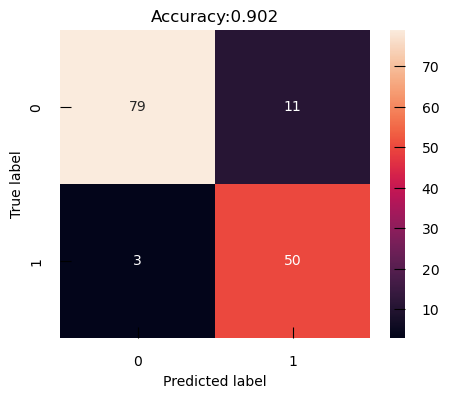

In [63]:
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns


y_cancer_test_pred = grid_lr_cancer_acc.predict(X_test_cancer)

# get the confusion matrix:
confusion_m_cancer = confusion_matrix(y_test_cancer, y_cancer_test_pred)

## recipe to plot the confusion matrix :
plt.figure(figsize=(5, 4))
sns.heatmap(confusion_m_cancer, annot=True)
plt.title("Accuracy:{0:.3f}".format(accuracy_score(y_test_cancer, y_cancer_test_pred)))
plt.ylabel("True label")
plt.xlabel("Predicted label");


<br>

---

<br>

**If you want to use a GLM other than the logistic regression:**
[GLM in sklearn](https://scikit-learn.org/stable/modules/linear_model.html#generalized-linear-regression)


<br>

[Back to the ToC](#toc)

<br>

# A few VERY IMPORTANT words on leakage. <a class="anchor" id="leakage"></a>

The most important part in all of the machine learning jobs that we have been presenting above, is that **the data set on which you train and the data set on which you evaluate your model should be clearly separated**(either the validation set when you do hyperparameter tunning, or test set for the final evaluation). 

No information directly coming from your test or your validation should pollute your train set. If it does you **loose your ablity to have a meaningful evaluation power.** 

In general **data leakage** relates to every bits of information that you should not have access to in a real case scenario, being present in your training set.

Among those examples of data leakage you could count : 
* **using performance on the test set to decide which algorithm/hyperparameter to use**
* doing imputation or scaling before the train/test split
* inclusion of future data points in a time dependent or event dependent model.


<br>

[Back to the ToC](#toc)

<br>

# Exercise : logistic regression <a class="anchor" id="exo-lr"></a>

The framingham dataset links some patient features to their risk to develop a heart disease.

In [65]:
df_heart = pd.read_csv("data/framingham.csv")

df_heart.dropna(axis=0, inplace=True)  # removing rows with NA values.

print(df_heart.shape)
df_heart.head()

(3658, 16)


male  age  education  currentSmoker  cigsPerDay  BPMeds  prevalentStroke  \
0     1   39        4.0              0         0.0     0.0                0   
1     0   46        2.0              0         0.0     0.0                0   
2     1   48        1.0              1        20.0     0.0                0   
3     0   61        3.0              1        30.0     0.0                0   
4     0   46        3.0              1        23.0     0.0                0   

   prevalentHyp  diabetes  totChol  sysBP  diaBP    BMI  heartRate  glucose  \
0             0         0    195.0  106.0   70.0  26.97       80.0     77.0   
1             0         0    250.0  121.0   81.0  28.73       95.0     76.0   
2             0         0    245.0  127.5   80.0  25.34       75.0     70.0   
3             1         0    225.0  150.0   95.0  28.58       65.0    103.0   
4             0         0    285.0  130.0   84.0  23.10       85.0     85.0   

   TenYearCHD  
0           0  
1           0  
2           0  
3           1  
4           0

Implement a logistic regression pipeline to predict the column `'TenYearCHD'` (dependent variable : ten year risk of coronary heart disease) by adapting some of the code above.

Assess the performance of your model, and list the features by order of their importance.


In [66]:
##separation in X and y
X_heart = df_heart.drop(columns="TenYearCHD")
y_heart = df_heart["TenYearCHD"]

Solution - reading and setup data

In [67]:
# %load -r -20 solutions/solution_03_01.py

Solution - separate between train and test set

In [68]:
# %load -r 22-30 solutions/solution_03_01.py

Solution - pipeline creation and fitting

In [69]:
# %load -r 32-50 solutions/solution_03_01.py

Solution - evaluation on the test set

In [70]:
# %load -r 51-71 solutions/solution_03_01.py

Solution - plotting the ROC curve

In [71]:
# %load -r 72-96 solutions/solution_03_01.py

Solution - getting feature importance

In [72]:
# %load -r 97- solutions/solution_03_01.py

<br>

[Back to the ToC](#toc)

<br>

# Support Vector Machine <a class="anchor" id="svm"></a>

## SVM for Classification <a class="anchor" id="svm-c"></a>

### introduction <a class="anchor" id="formal-svm-c"></a>

"The basic principle of SVM is pretty simple. SVM aims at finding the 'good' threshold (hyperplane) to separate data from different classes. Conceptually it is very different from logistic regression where you maximize the log likelihood of the log odds function. **With SVM you really look for an hyperplane that separates data and that's it : there is no underlying hypothesis about probability distribution or anything else. It is very geometrical.**

So what's a good threshold? Again it is going to depend on the metric you are interested in. But at least a good threshold should be linked to this biais variance trade off in the sense that it should offer flexibility to your model.

You can imagine that there is a quite a lot of hyperplanes separating data in your training set. You could stick your threshold right where the class 0 point closest to class 1 lies. But in that case it will be very far from the other class 0 points, which can be a problem. **You could decide that your threshold should be right between the two closest extreme of your classes but that is going to be very sensitive to missclassified data or extreme events... Those points choosen as a reference to put your threshold are called support vectors.**

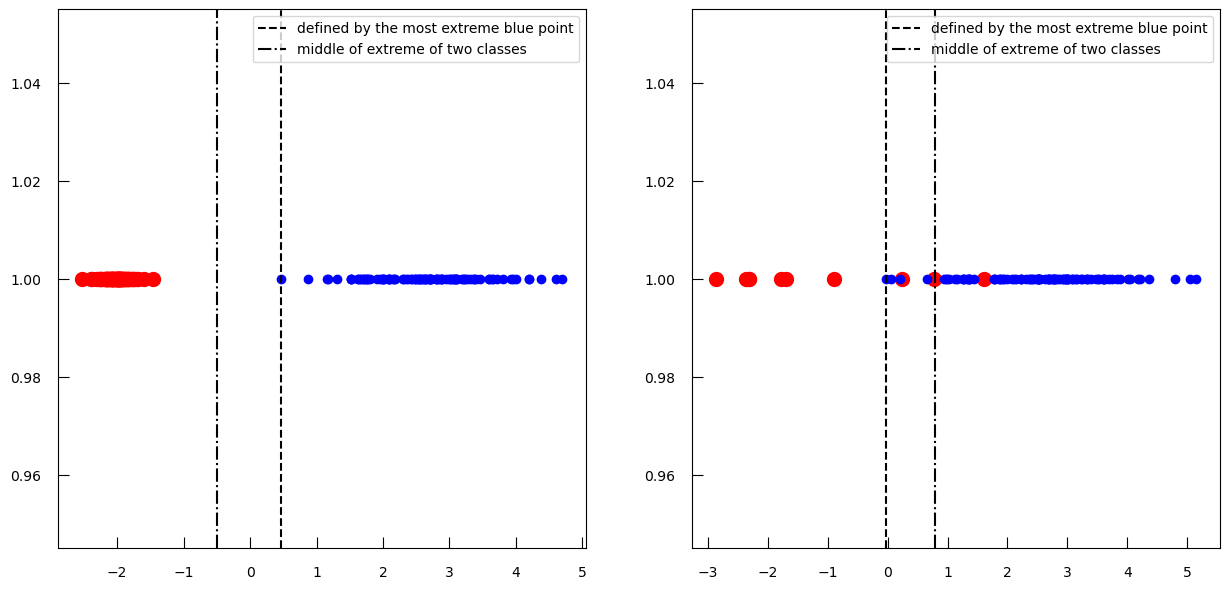

In [73]:
np.random.seed(10815657)


fig, ax = plt.subplots(1, 2, figsize=(15, 7))

# case 1
norm1 = 0.2 * np.random.randn(100) - 2
norm2 = 0.8 * np.random.randn(100) + 2.5
ax[0].plot(norm1, [1] * 100, "ro", markersize=10)
ax[0].plot(norm2, [1] * 100, "bo")

min2 = min(norm2)
max1 = max(norm1)

ax[0].axvline(
    min2, color="k", linestyle="--", label="defined by the most extreme blue point"
)
ax[0].axvline(
    (min2 + max1) / 2,
    color="k",
    linestyle="-.",
    label="middle of extreme of two classes",
)
ax[0].legend(loc="best")


# case 2
cauch = 0.8 * np.random.standard_cauchy(10) - 2
norm = 1 * np.random.randn(100) + 2.5

ax[1].plot(cauch, [1] * 10, "ro", markersize=10)
ax[1].plot(norm, [1] * 100, "bo")

min2 = min(norm)
max1 = max(cauch)

ax[1].axvline(
    min2, color="k", linestyle="--", label="defined by the most extreme blue point"
)
ax[1].axvline(
    (min2 + max1) / 2,
    color="k",
    linestyle="-.",
    label="middle of extreme of two classes",
)
ax[1].legend(loc="best")


On the left panel, the two hyperplanes are valid separation but you can imagine that the plane defined by the most extreme blue point doesn't leave much space for generalization

If your data are not linearly separable, like in the right panel, you need to be able to choose support vectors that are going to do some misclassification but for the greater good.

So, once again, you are confronted to a compromise. You should place your threshold somwhere that is globally best even though that would mean some miss-classification. We are back to our regularization problem and of course **Support vector machine has a regularization parameter : C**. The game now becomes placing your threshold right in the middle of points (support vectors) from  each classes that you have \"chosen\" to be general points for decision making : **they don't need to be the two closest points from different classes anymore. They need to be points where your hyperplane makes the least error differentiating classes.**


![svm](image/1920px-SVM_margin.png)

Image source : image by wikipedia user Larhmam, distributed under a [CC BY-SA 4.0 license](https://creativecommons.org/licenses/by-sa/4.0/deed.en).


So you want to maximize the margin separating the two classes. This margin is $\frac{2}{||\pmb{w}||}$. So you want to minimize $||\pmb{w}||$. The SVM loss function we want to minimize with respect to $\pmb{w}$ and $b$ is:

$C\cdot\Sigma^{N}_{i=1}\zeta_i + \frac{1}{2}||\pmb{w}||^{2}$ subject to $\zeta_i \ge 0$ and $y_{i}(w^{T}x_{i}-b) \ge 1-\zeta_i$, where $\zeta_i = \Sigma^{N}_{i=1}max(0,1-y_{i}(\pmb{w}\cdot\pmb{x}_i-b))$
 * $y_i$ is $-1$ or $1$ depending on the class of the point $i$
 * the class of point $\pmb{x}$ is determined by the SVM using the sign of $(\pmb{w}\cdot\pmb{x}-b)$ (ie, on which side of the $(\pmb{w}\cdot\pmb{x}-b)$ hyperplane we are).



Note that you could also use a L1 regularization but it is not implemented in the function we are going to use.

Indeed if most of the data points are well separated in term of class on each side of the hyperplane then
* most of the time $y_{k}(w^{T}x_{k}-b) \geq 1$ and so $max(0,1-y_{k}(w^{T}x_{k}-b)=0$ (that's good for minimizing our loss function), 
* and a few times $y_{k}(w^{T}x_{k}-b) \leq -1$ and so $max(0,1-y_{k}(w^{T}x_{k}-b) \geq 2$ (which is polluting our minimization of the loss function).



You can see that there is a [dot product](https://en.wikipedia.org/wiki/Dot_product) involved : in the case of a linear hyperplane this dot product is just the cartesian dot product that you probably use all the time. It allows you to calculate distances between points in that cartesian space or between points and hyperplanes. But you might be familiar with other scalar product : like for example when you proceed to a Fourier decomposition of a function. This particular scalar product acts on functions and so is not really of interest for us... But others exist.

**So in principle you could use other definitions of distance between points to answer that classification question**. This is what non-linear SVM does and this is why you can choose different so called kernels as hyperparameters as we will see below :

$\overrightarrow{x_{i}}.\overrightarrow{x_{j}}$ : cartesian

$(\overrightarrow{x_{i}}.\overrightarrow{x_{j}})^{d}$ : polynomial degree d

$exp(-\gamma||\overrightarrow{x_{i}}-\overrightarrow{x_{j}}||^{2})$ : gaussian radial basis

$tanh(\kappa\overrightarrow{x_{i}}.\overrightarrow{x_{j}}+c)$ : hyperbolic tangent

**This is really powerful for classification but going non-linear by using a kernel trick prevents you from interpreting how your features are massaged to create this classifier... So, if you want interpretability and do science rather than engineering : keep it linear.**

![3d_svm](image/3d_svm.png)

> Even though SVM as nothing to do with probablities, we are going to transform the results of our classifier back to probabilities (using logistic regression...) to be able to draw a ROC curve. But again I insist, those are just useful transformations but has actually nothing to do with the technique.

[Back to the toc](#toc)

### Toy example to visualize SVMC <a class="anchor" id="toy-example-svm-c"></a>

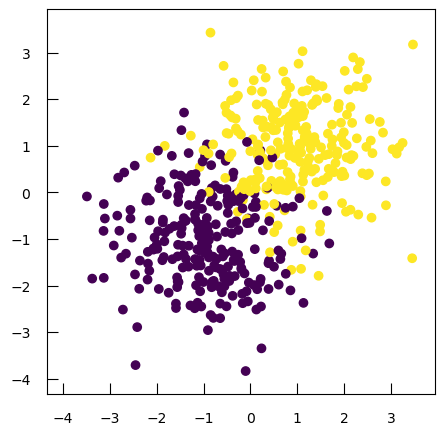

In [74]:
from sklearn.datasets import make_blobs

X2, y2 = make_blobs(n_samples=(250, 250), centers=[[-1, -1], [1, 1]], random_state=6)
plt.scatter(X2[:, 0], X2[:, 1], c=y2)
plt.xlim(min(X2[:, 1]) - 0.5, max(X2[:, 1]) + 0.5)
plt.ylim(min(X2[:, 1]) - 0.5, max(X2[:, 1]) + 0.5)
plt.show()

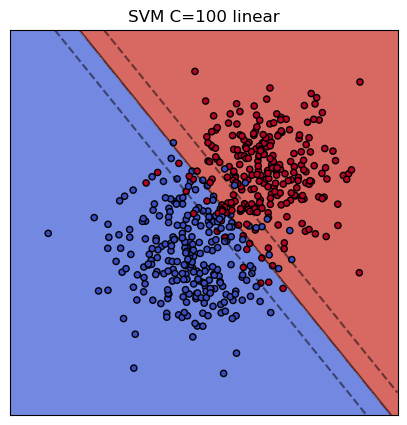

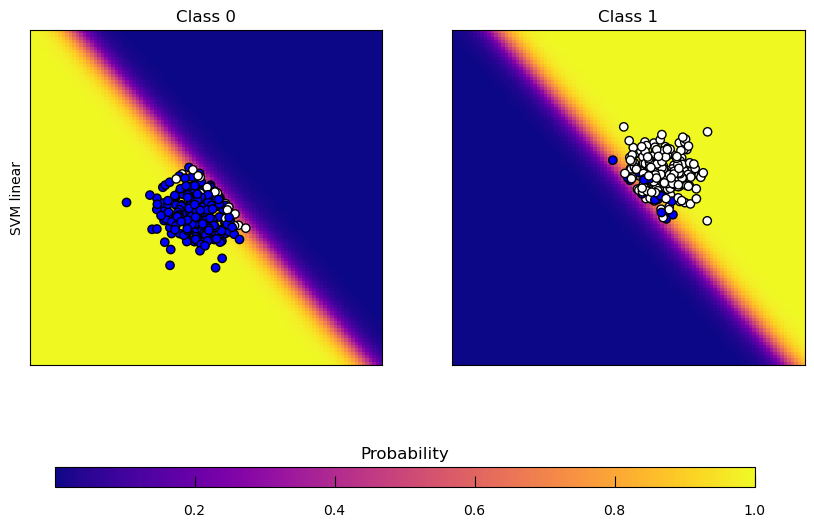

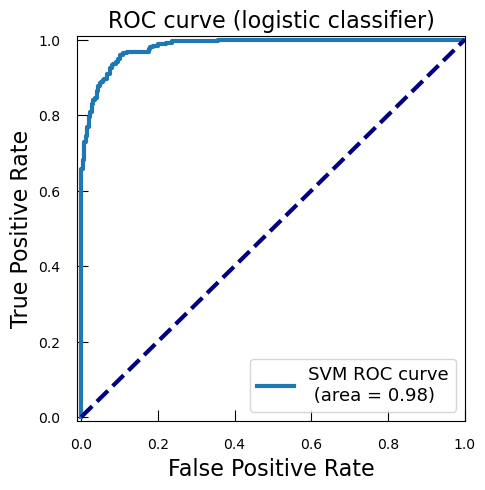

In [75]:
from utils import contour_SVM

contour_SVM(X2, y2, c=100, ker="linear")

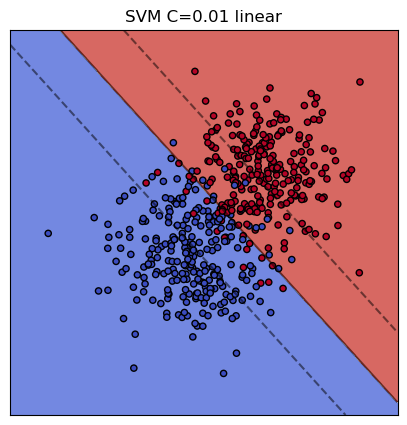

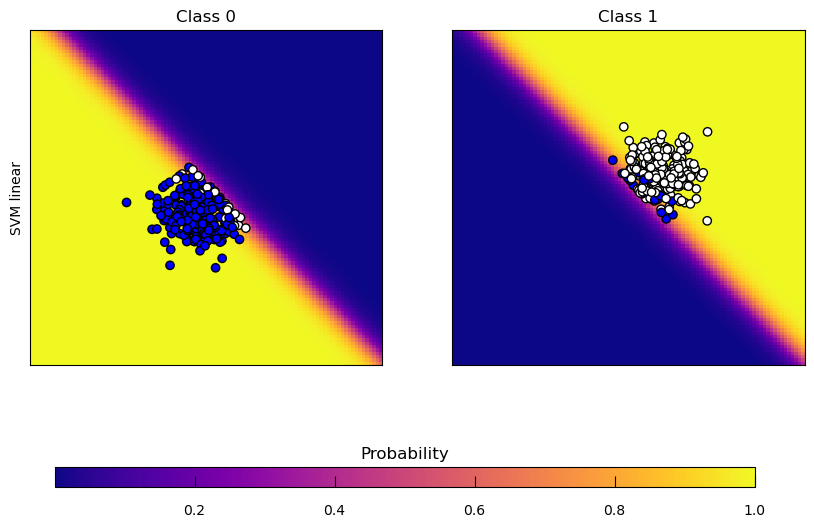

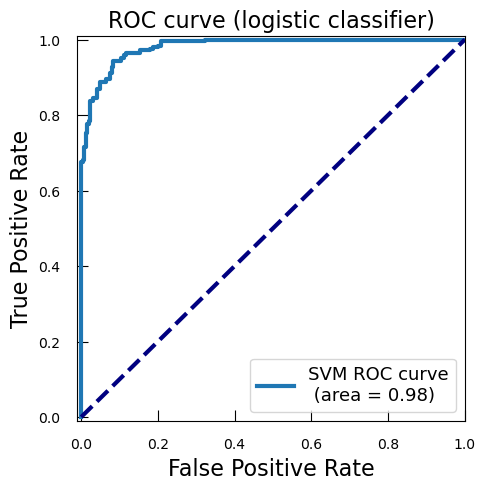

In [76]:
contour_SVM(X2, y2, c=0.01, ker="linear")

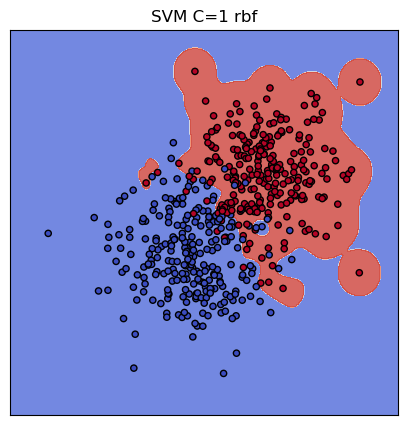

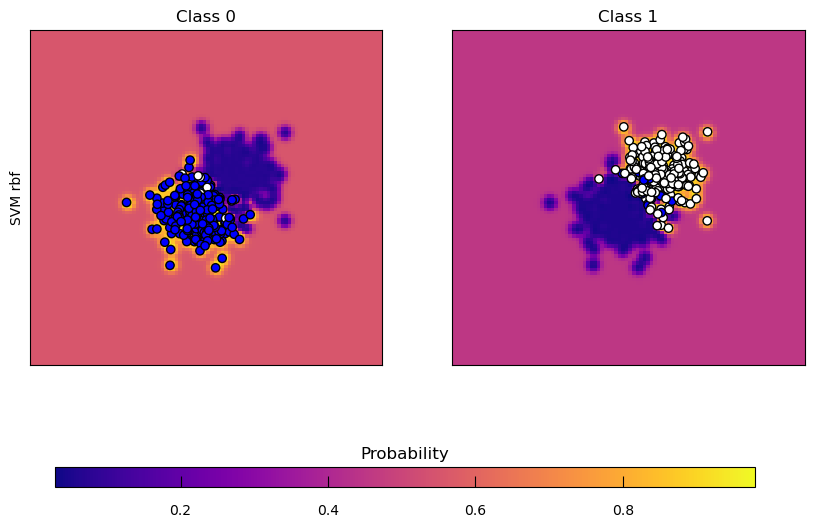

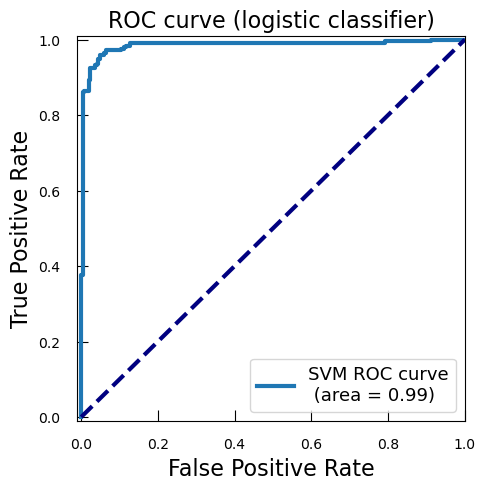

In [77]:
contour_SVM(X2, y2, c=1, ker="rbf", gam=10)

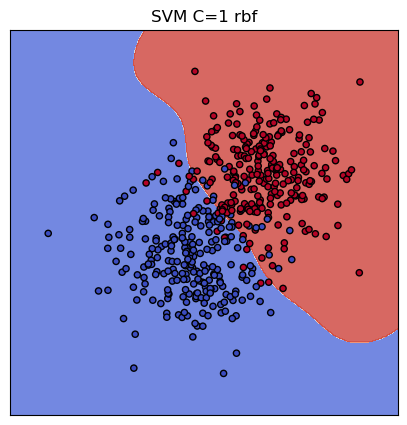

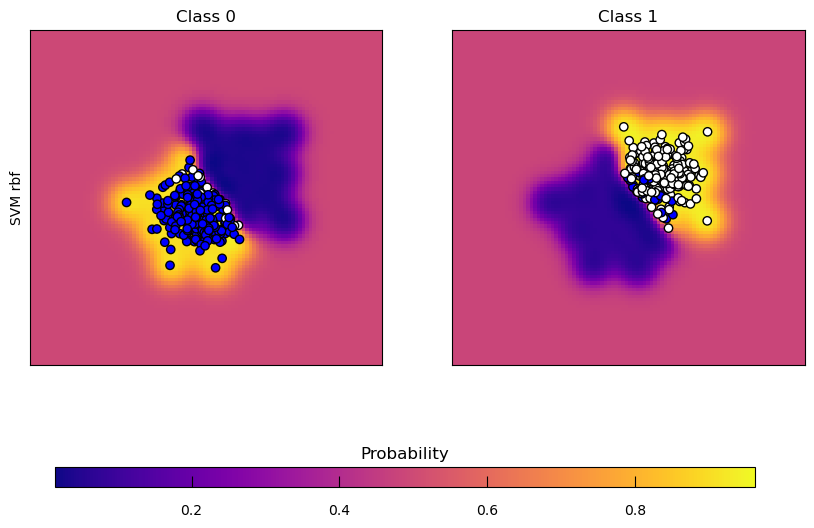

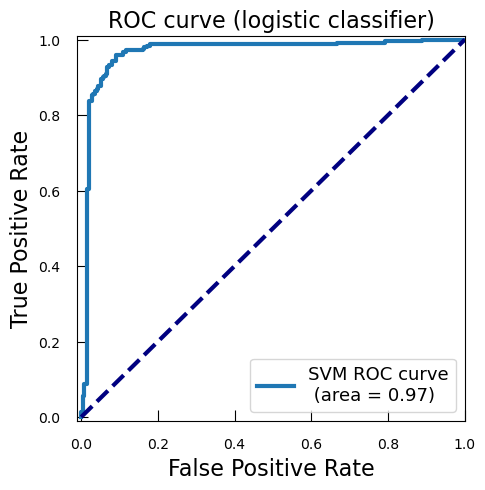

In [78]:
contour_SVM(X2, y2, c=1, ker="rbf", gam=1)

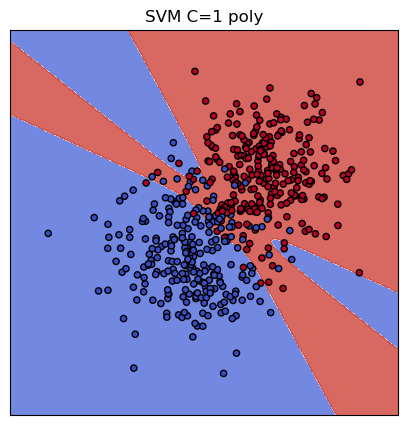

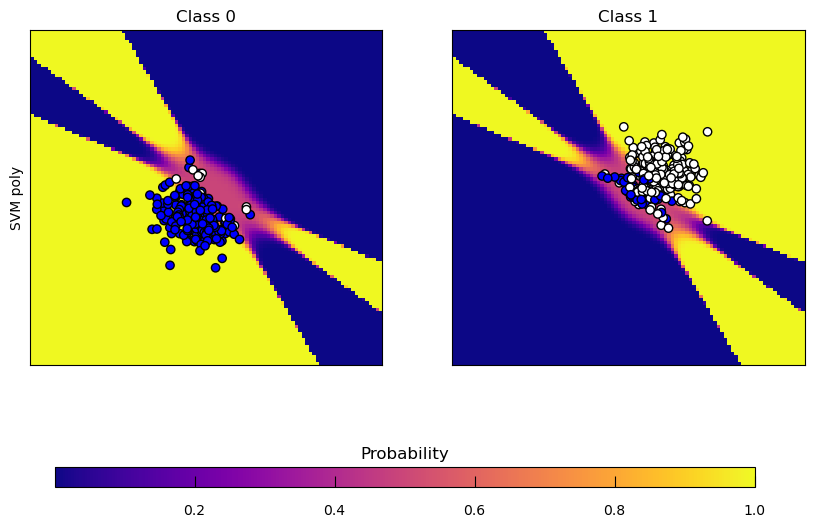

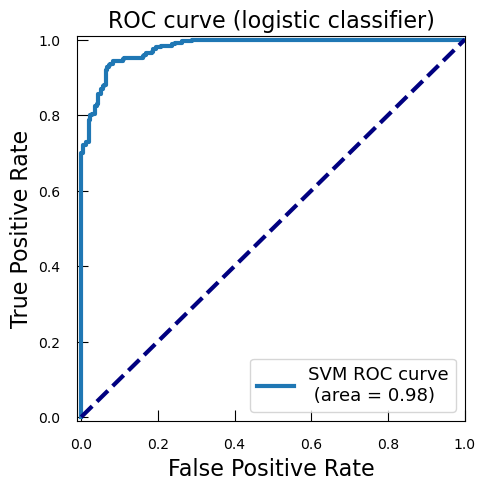

In [79]:
contour_SVM(X2, y2, c=1, ker="poly", deg=5)

[Back to the toc](#toc)

### SVM Classifier pipeline. <a class="anchor" id="svm-c-pipeline"></a>

In sklearn SVM classifier is implemented in a single `sklearn.svm.SVC` class,
but as we have seen depending on the kernel you have different parameters.

That means that when you specify the grid of hyper-parameters to explore, you could write something like this:

```python
grid_values = {"model__kernel": ['linear', 'rbf', 'poly'],
                 "model__C":np.logspace(-2, 2, 10),
                 "model__degree":[2,3,4,5],
                 "model__gamma": np.logspace(-2,1,10)}
```

That would work, however that means that even though parameter `gamma` is useless when the kernel is `'linear'`, the GridSearchCV will still test all the different combination of values.
On this example, rather than testing :
 * 10 combinations for linear kernel (C)
 * 10*4 = 40 combinations for poly kernel (C and degree)
 * 10*10 = 100 combinations for rbf kernel (C and gamma)

= 150 combinations to test.

You would test $3*10*4*10 = 1200$ combinations...

Let's see how we can handle this smartly to avoid these useless computations.

In [80]:
%%time
from sklearn.svm import SVC

## set up the pipeline as usual
pipe = Pipeline([("scalar", StandardScaler()), ("classifier", SVC())])

# the grid of parameter values is not a dictionnary, but now a list
#  of dictionnaries : smaller grid to explore independently

# for each of these grid, we can re-define locally the classifier
grid_param = [
    {
        "classifier": [SVC(class_weight="balanced", probability=True, kernel="linear")],
        "classifier__C": np.logspace(-2, 2, 10),
    },
    {
        "classifier": [SVC(class_weight="balanced", probability=True, kernel="rbf")],
        "classifier__C": np.logspace(-2, 2, 10),
        "classifier__gamma": np.logspace(-2, 1, 10),
    },
    {
        "classifier": [SVC(class_weight="balanced", probability=True, kernel="poly")],
        "classifier__C": np.logspace(-2, 2, 10),
        "classifier__degree": [2, 3, 4, 5],
    },
]
## NB : we use probability = True in order to make ROC auc computation possible later on

grid_svm = GridSearchCV(
    pipe, grid_param, cv=5, verbose=0, n_jobs=-1, scoring="accuracy"
)

grid_svm.fit(X_train_cancer, y_train_cancer)

# get the best cross-validated score
print("Grid best score (" + grid_svm.scoring + "): ", grid_svm.best_score_)
# print the best parameters
print("Grid best kernel    :", grid_svm.best_params_["classifier"].kernel)
print("Grid best parameter :")
for k, v in grid_svm.best_params_.items():
    print(" {:>20} : {}".format(k, v))


Grid best score (accuracy):  0.9507250341997265
Grid best kernel    : rbf
Grid best parameter :
           classifier : SVC(class_weight='balanced', probability=True)
        classifier__C : 35.93813663804626
    classifier__gamma : 0.09999999999999999
CPU times: user 936 ms, sys: 70.6 ms, total: 1.01 s
Wall time: 1.18 s


Alternatively, the same as above could be done with multiple separate grid searchs. We would **compare them by their cross-validated score** : `grid.best_score_`.

In [81]:
%%time
from sklearn.svm import SVC

scoring_metric = "accuracy"

# linear kernel
pipe1 = Pipeline(
    [
        ("scalar", StandardScaler()),
        ("classifier", SVC(class_weight="balanced", probability=True, kernel="linear")),
    ]
)
grid_param1 = {"classifier__C": np.logspace(-2, 2, 10)}

grid_svm_linear = GridSearchCV(
    pipe1, grid_param1, cv=5, verbose=0, n_jobs=-1, scoring=scoring_metric
)

# rbf kernel
pipe2 = Pipeline(
    [
        ("scalar", StandardScaler()),
        ("classifier", SVC(class_weight="balanced", probability=True, kernel="rbf")),
    ]
)
grid_param2 = {
    "classifier__C": np.logspace(-2, 2, 10),
    "classifier__gamma": np.logspace(-2, 1, 10),
}

grid_svm_rbf = GridSearchCV(
    pipe2, grid_param2, cv=5, verbose=0, n_jobs=-1, scoring=scoring_metric
)

# poly kernel
pipe3 = Pipeline(
    [
        ("scalar", StandardScaler()),
        ("classifier", SVC(class_weight="balanced", probability=True, kernel="poly")),
    ]
)
grid_param3 = {
    "classifier__C": np.logspace(-2, 2, 10),
    "classifier__degree": [2, 3, 4, 5],
}

grid_svm_poly = GridSearchCV(
    pipe3, grid_param3, cv=5, verbose=0, n_jobs=-1, scoring=scoring_metric
)


grid_svm_linear.fit(X_train_cancer, y_train_cancer)
grid_svm_rbf.fit(X_train_cancer, y_train_cancer)
grid_svm_poly.fit(X_train_cancer, y_train_cancer)


print(
    "linear Grid best score (" + grid_svm_linear.scoring + "): ",
    grid_svm_linear.best_score_,
)
print(
    "   rbf Grid best score (" + grid_svm_rbf.scoring + "): ", grid_svm_rbf.best_score_
)
print(
    "  poly Grid best score (" + grid_svm_poly.scoring + "): ",
    grid_svm_poly.best_score_,
)

linear Grid best score (accuracy):  0.9366621067031463
   rbf Grid best score (accuracy):  0.9507250341997265
  poly Grid best score (accuracy):  0.9201641586867304
CPU times: user 1.13 s, sys: 102 ms, total: 1.24 s
Wall time: 1.59 s


In the end we get the same result.

> This is also the approach we would take to decide between logistic regression, SVM, or other models.

Anyhow, let's look at the best model performance in more depth:

In [82]:
y_cancer_test_score = grid_svm.score(X_test_cancer, y_test_cancer)

print(
    "Grid best parameter (max." + grid_svm.scoring + ") model on test: ",
    y_cancer_test_score,
)

Grid best parameter (max.accuracy) model on test:  0.9090909090909091


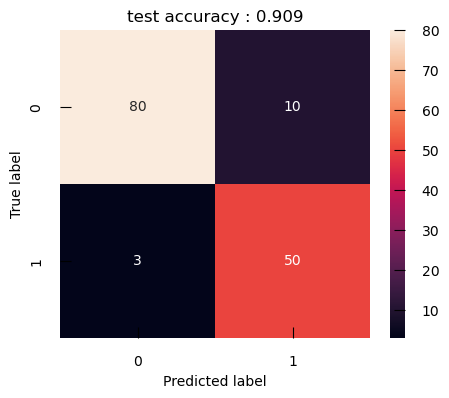

In [83]:
y_cancer_pred_test = grid_svm.predict(X_test_cancer)

confusion_m_cancer_SVMC = confusion_matrix(y_test_cancer, y_cancer_pred_test)

plt.figure(figsize=(5, 4))
sns.heatmap(confusion_m_cancer_SVMC, annot=True)

plt.ylabel("True label")
plt.xlabel("Predicted label")
plt.title("test {} : {:.3f}".format(grid_svm.scoring, y_cancer_test_score));

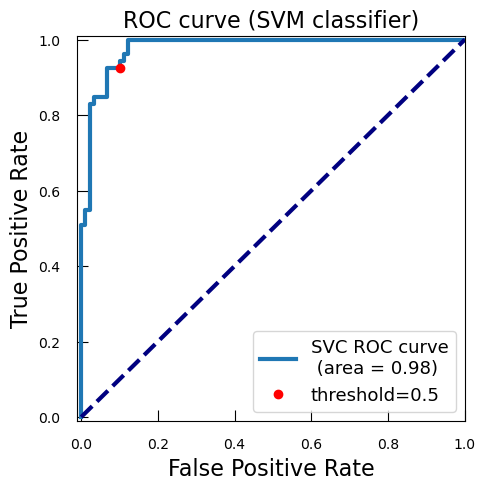

In [84]:
y_cancer_score_SVMC = grid_svm.decision_function(X_test_cancer)
fpr_SVMC_cancer, tpr_SVMC_cancer, thre_SVMC_cancer = roc_curve(
    y_test_cancer, y_cancer_score_SVMC
)
roc_auc_SVMC_cancer = auc(fpr_SVMC_cancer, tpr_SVMC_cancer)

proba = expit(thre_SVMC_cancer)
for i in range(len(proba)):
    if abs(proba[i] - 0.5) < 0.1:
        keep = i
        break


plt.figure()
plt.xlim([-0.01, 1.00])
plt.ylim([-0.01, 1.01])
plt.plot(
    fpr_SVMC_cancer,
    tpr_SVMC_cancer,
    lw=3,
    label="SVC ROC curve\n (area = {:0.2f})".format(roc_auc_SVMC_cancer),
)
plt.plot(fpr_SVMC_cancer[keep], tpr_SVMC_cancer[keep], "ro", label="threshold=0.5")
plt.xlabel("False Positive Rate", fontsize=16)
plt.ylabel("True Positive Rate", fontsize=16)
plt.title("ROC curve (SVM classifier)", fontsize=16)
plt.legend(loc="lower right", fontsize=13)
plt.plot([0, 1], [0, 1], color="navy", lw=3, linestyle="--")
# plt.axes().set_aspect('equal')
plt.show()

And here the kernel is RBF, so we have no coefficients to grab from the model for interpretation.

But, we still have some options.

For instance, we present here [permutation feature importance](https://scikit-learn.org/stable/modules/permutation_importance.html): it is the **decrease in a model score when a single feature value is randomly shuffled**.


In [85]:
%%time
from sklearn.inspection import permutation_importance

r = permutation_importance(
    grid_svm.best_estimator_,
    X_test_cancer,
    y_test_cancer,
    n_repeats=1000,
    random_state=132987,
)

for i in r.importances_mean.argsort()[::-1]:
    if r.importances_mean[i] - 2 * r.importances_std[i] > 0:
        print(
            f"{breast_cancer_df.columns[i]:<8}"
            f"{r.importances_mean[i]:.3f}"
            f" +/- {r.importances_std[i]:.3f}"
        )


mean area0.091 +/- 0.022
mean concavity0.057 +/- 0.022
mean texture0.037 +/- 0.018
CPU times: user 12.2 s, sys: 2.29 ms, total: 12.2 s
Wall time: 12.2 s


Other methods exists to help analyse black-boxxy models, such as [SHAP](https://shap.readthedocs.io/en/latest/example_notebooks/tabular_examples/model_agnostic/Iris%20classification%20with%20scikit-learn.html)

<br>

[Back to the ToC](#toc)

<br>

## SVM for Regression <a class="anchor" id="svm-r"></a>

We could use the same algorithm for regression, with the only difference that this time instead of finding the hyperplane that is the farthest from the support, we find the hyperplane that is the closest from those support. 

For example, on our diabete data set, just by replacing SVC by SVR. 
We just use the `'rbf'` kernel (the linear and poly have already been tested with our OLS model earlier).

In [86]:
%%time
from sklearn.svm import SVR
## SVR for regression

pipeline_SVR = Pipeline([("scalar", StandardScaler()), ("model", SVR(kernel="rbf"))])

grid_values = {
    "model__C": np.logspace(-2, 2, 20),
    "model__gamma": np.logspace(-2, 2, 20),
}

## don't forget to change the metric to one adapted for regression:
grid_SVR_diabetes = GridSearchCV(
    pipeline_SVR, param_grid=grid_values, scoring="r2", n_jobs=-1
)

grid_SVR_diabetes.fit(X_diabetes_train, y_diabetes_train)

print(
    "Grid best score (" + grid_SVR_diabetes.scoring + "): ",
    grid_SVR_diabetes.best_score_,
)
print(
    "Grid best parameter (max." + grid_SVR_diabetes.scoring + "): ",
    grid_SVR_diabetes.best_params_,
)


Grid best score (r2):  0.4972454469408552
Grid best parameter (max.r2):  {'model__C': 37.92690190732246, 'model__gamma': 0.02636650898730358}
CPU times: user 2.12 s, sys: 177 ms, total: 2.3 s
Wall time: 2.27 s


If you remember, our OLS model was able to get an $R^2$ of $~0.52$.

So we gain a tiny bit of $R^2$, but we loose interpretability ... not the best trade here.

Let's still have a look at the model predictions : 

In [87]:
y_diabetes_test_score = grid_SVR_diabetes.score(X_diabetes_test, y_diabetes_test)
print(
    "Grid best parameter (max." + grid_SVR_diabetes.scoring + ") model on test: ",
    y_diabetes_test_score,
)

Grid best parameter (max.r2) model on test:  0.49630966938565035


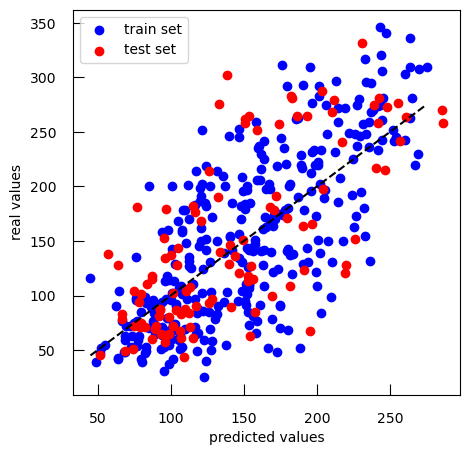

In [88]:
## train prediction
y_diabetes_train_pred = grid_SVR_diabetes.predict(X_diabetes_train)
## test prediction
y_diabetes_test_pred = grid_SVR_diabetes.predict(X_diabetes_test)


plt.scatter(y_diabetes_train_pred, y_diabetes_train, c="blue", label="train set")
plt.scatter(y_diabetes_test_pred, y_diabetes_test, c="red", label="test set")
m, M = min(y_diabetes_train_pred), max(y_diabetes_train_pred)
plt.plot([m, M], [m, M], "k--")
plt.xlabel("predicted values")
plt.ylabel("real values")
plt.legend()

<br>

<!-- Exo : try a  linear kernel. Can you say anything about feature importance? How would you compare this new model to the former. %load  solutions/solution_03_mini.py -->

 ---

<br>

[Back to the ToC](#toc)

<br>

# Decision tree modeling : a (new?) loss function and new ways to do regularization. <a class="anchor" id="decision-tree"></a>

## Simple decision tree for classification. <a class="anchor" id="simple-tree-c"></a>

A simple **decision tree** reduces your problem into a **hierarchichal sequence of questions** on your features that can be answered by yes or no and which subdivides the data into 2 subgroups on which a new question is asked, and so on and so on.
![tree_ex](image/tree_ex.png)

Ok, but a huge number of trees can actually be built just by considering the different orders of questions asked. How does the algorithm deals with this?

Quite simply actually: it **tests all the features and chooses the most discriminative** (with respect to your target variable) : the feature where a yes or no question divides the data into 2 subsets which minimizes an **impurity measure**.

Imagine you have a dataset with feature color (red or blue) and feature shape (square or circle), and 2 target classes : 1 and 2.


![tree](image/Tree.png)

Asking `"feature color is red"` gives you the following subgroups:
 * 10 class 1, and 1 class 2 (`"feature color is red" == True`)
 * 2 class 1, and 11 class 2 (`"feature color is red" == False`)

Asking `"feature shape is square"` gives you:
 * 5 class 1, and 7 class 2 (`True`) 
 * 7 class 1 and 5 class 2 (`False`)
 
 So, you will prefer asking `"feature color is red?"` over `"feature shape is square?"`: `"feature color is red?"` is more discriminative.

For **categorical variables, the questions test for a specific category**.
For **numerical variables, the questions use a threshold** to as a yes/no question.  

The **threshold is, again, chosen to minimize impurity**. And in turn the best threshold for a variable is used to estimate the discriminativeness of that variable.

Of course, you will have to compute this threshold at each step of your tree since at each step you are considering different subdatasets.

---
The **impurity is related to how much your feature splitting is still having mixed classes**. So the impurity ends up giving a score: either it is a simple [Shannon entropy](https://en.wikipedia.org/wiki/Entropy_(information_theory)) or it is a [Gini coefficient](https://en.wikipedia.org/wiki/Gini_coefficient).

#### Shannon Entropy

$$Entropy = - \sum_{j} p_j log_2(p_j)$$

This measure is linked to information theory, where the information of an event occuring is the $log_2$ of this event's probability of occuring.
For purity, **0 is the best possible score, and 1 the worst**.

#### Gini coefficient

$$Gini = 1- \sum_{j} p_j^2$$

The idea is to measure the **probability that a dummy classifier mislabels your data**.
**0 is best, 1 is worst.**

---
Before going further, just a little bit of vocabulary: 
* **Trees** are made of **nodes** (where the question is asked and where the splitting occurs). 
* A **branch** is the outcome of a splitting. 
* A **leaf** is the last node on a branch (no more splitting).

[Back to the ToC](#toc)

### Toy example to visualize decision tree. <a class="anchor" id="toy-decision-tree"></a>

Let explore some hyperparameters of this method that, you will see in those examples, act like a regularization:
- **Max Tree depth**: the maximum number of consecutive questions to ask
- **Min Splitting of nodes**: minimum number of points to consider to make a new rule, outside of the leaves
- **Min Splitting of leaves**: minimum number of points to consider to make a new rule, at the leaves

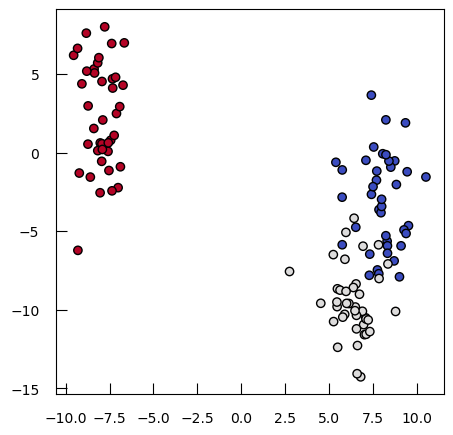

In [89]:
X_3, y_3 = make_blobs(
    n_samples=120, centers=3, cluster_std=[[1, 3], [1, 3], [1, 3]], random_state=6
)
plt.scatter(X_3[:, 0], X_3[:, 1], c=y_3, cmap=plt.cm.coolwarm, edgecolors="k")

In [90]:
from sklearn.tree import DecisionTreeClassifier

## creating a decision tree with 1 parameter changed (more on that later)
tree = DecisionTreeClassifier(max_depth=3)
tree.fit(X_3, y_3)

DecisionTreeClassifier(max_depth=3)

In [91]:
pd.crosstab(tree.predict(X_3), y_3, rownames=["truth"], colnames=["prediction"])

prediction   0   1   2
truth                 
0           35   2   0
1            5  38   0
2            0   0  40

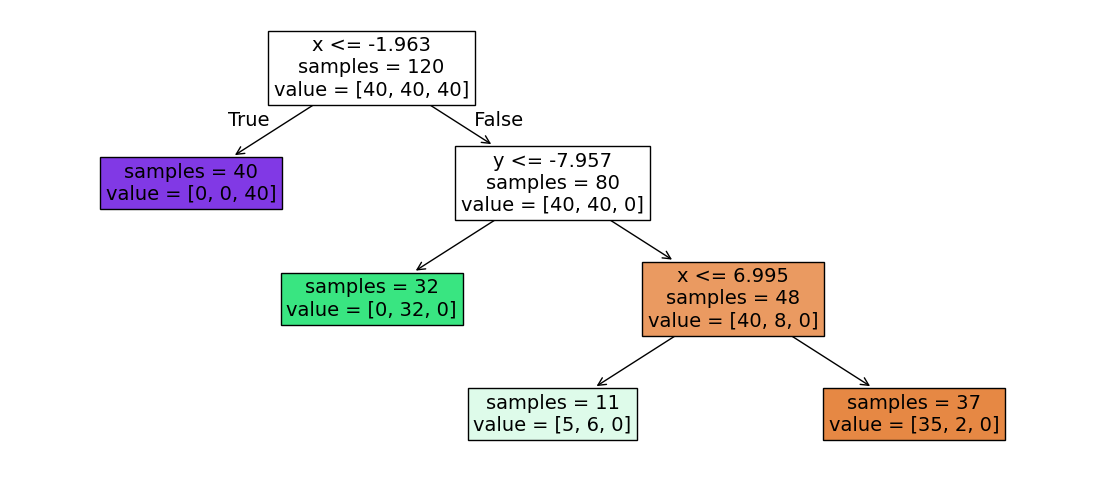

In [92]:
from sklearn.tree import plot_tree

fig, ax = plt.subplots(figsize=(14, 6))

_ = plot_tree(
    tree,
    feature_names=["x", "y"],
    fontsize=14,
    filled=True,
    impurity=False,
    precision=3,
    ax=ax,
)

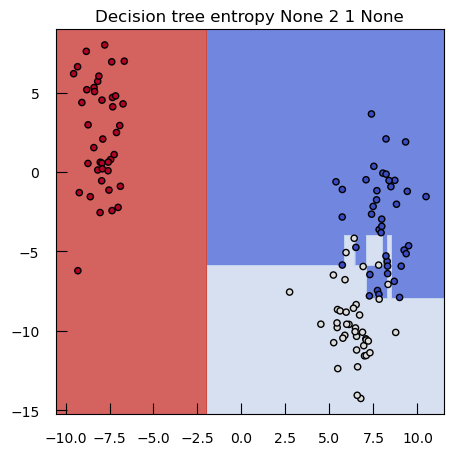

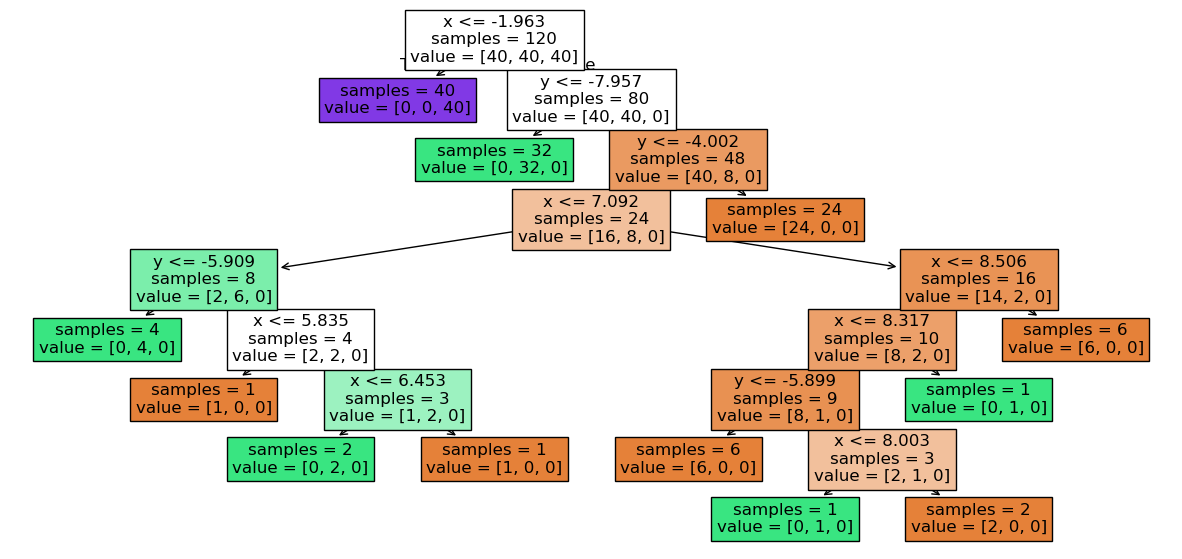

In [93]:
from utils import contour_tree

contour_tree(X_3, y_3, crit="entropy", maxd=None, min_s=2, min_l=1, max_f=None)
# You can see that there are 5 hyperparameters here. Let's see what they do and what they mean.
# I bet you can already guess it is going to be related to regularization....
# After X,y you have
# * crit = 'entropy' which is one way to calculate impurity (you could also put gini here)
# * maxd : the max depth of your tree
# * min_s : the number of points that should be concerned by the making of a new rule (splitting of the nodes)
# * min_l : #of points that should be considered to make a final leaf classification
# * max_f maximum number of features to consider for making a new rule...

This is an incredibly complex model. 

Please, note that since every node is a question asked on one particular feature and features are never directly compared, you don't need scaling! This observation that each question always involves one feature at a time can be also seen in the way the boundaries between classes are made in the graph : there is no diagonal boundaries. You can only see lines parallel to the plot axes.

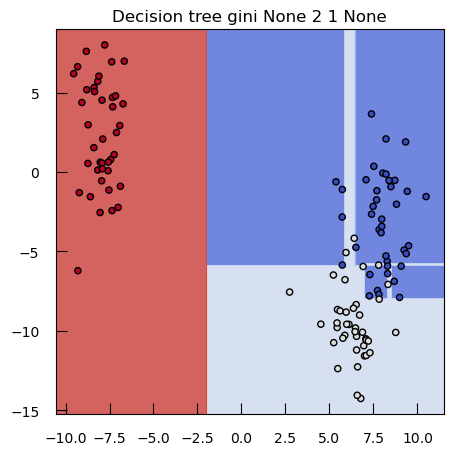

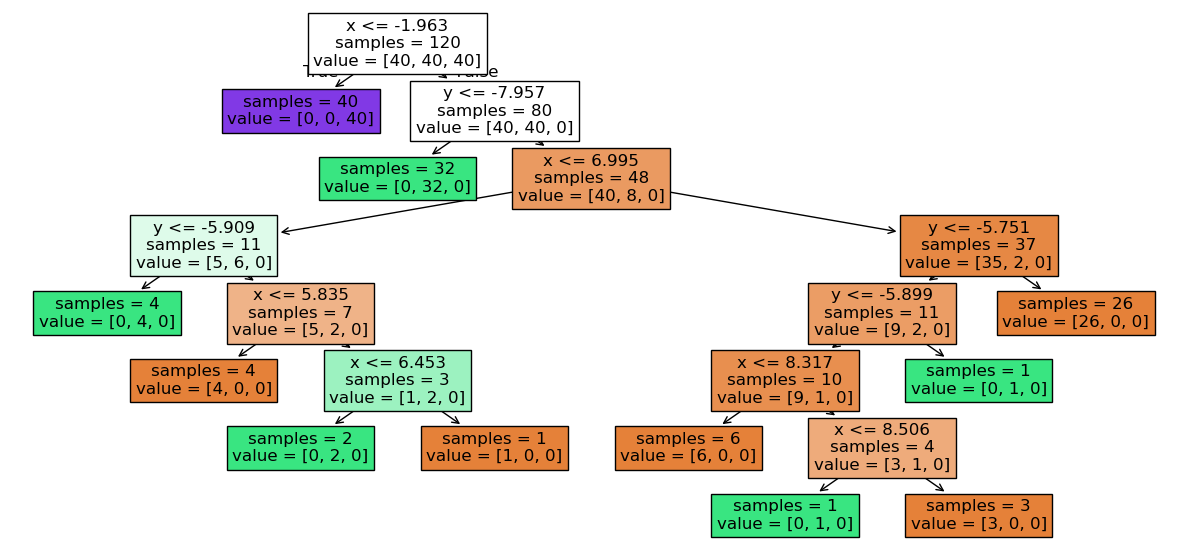

In [94]:
# using another impurity measurement
contour_tree(X_3, y_3, crit="gini", maxd=None, min_s=2, min_l=1, max_f=None)

Still some overfitting but it is nice to see that the boundaries are different and that impurity calculations, even if very similar, are making a difference.

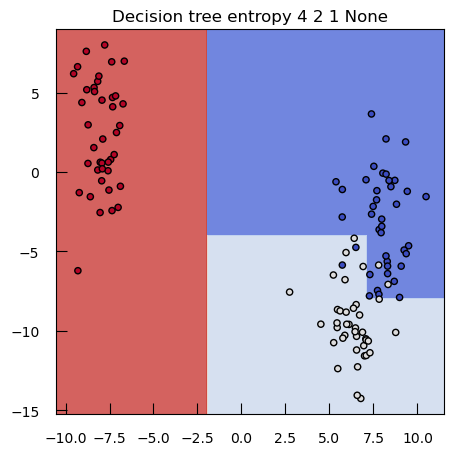

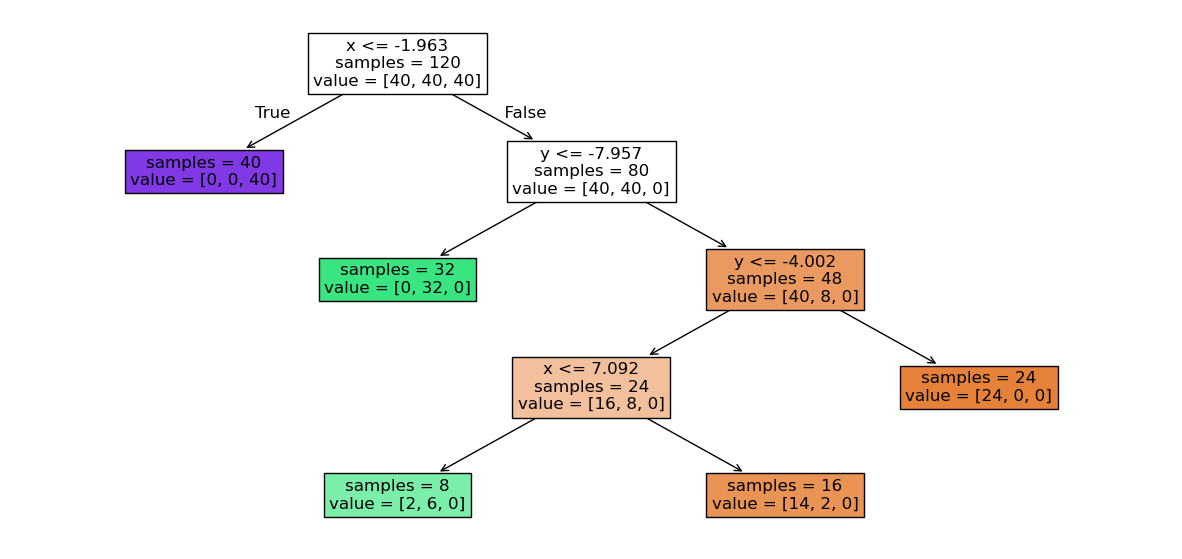

In [95]:
# Imposing a limit for the depth of the tree : how many questions you ask (here set to 4)
contour_tree(X_3, y_3, crit="entropy", maxd=4, min_s=2, min_l=1, max_f=None)

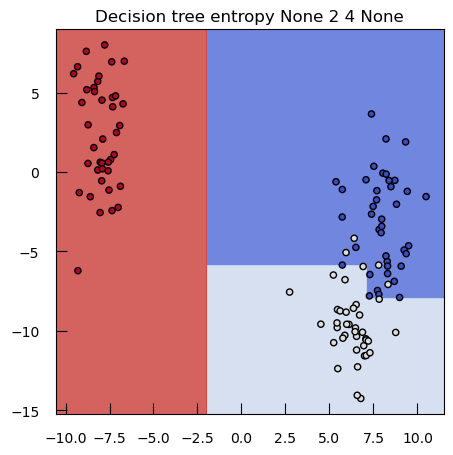

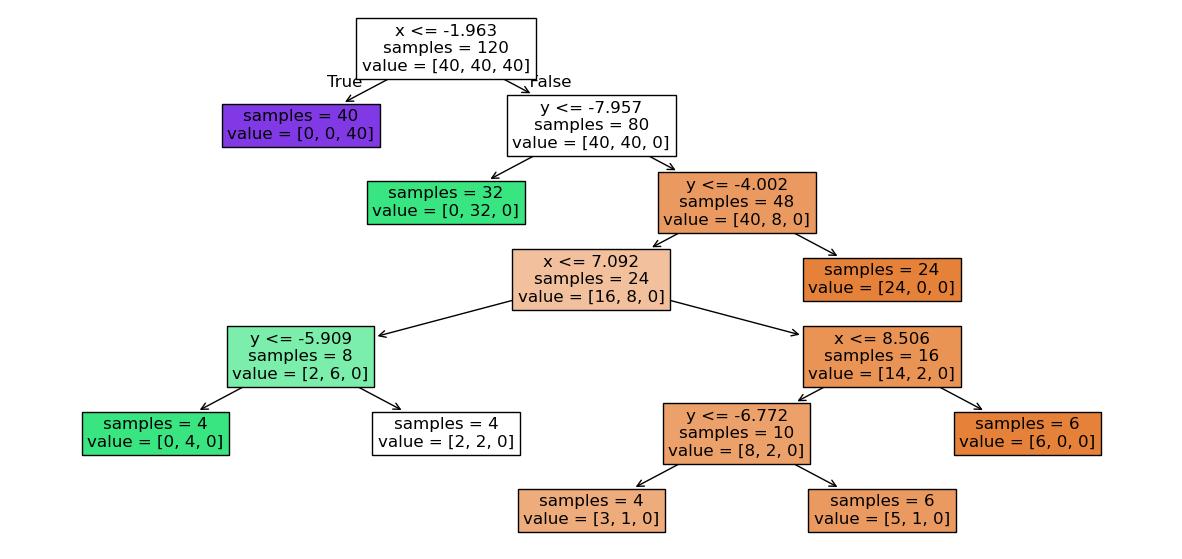

In [96]:
contour_tree(X_3, y_3, crit="entropy", maxd=None, min_s=2, min_l=4, max_f=None)
# min_samples_leaf :
#     it sets the minimal number of data points that the chain of rules should concern.

# eg. Do you really wish to create a whole new set of rules to explain
# only one particular data point?

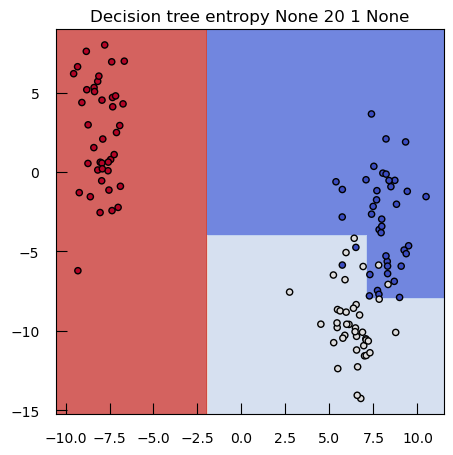

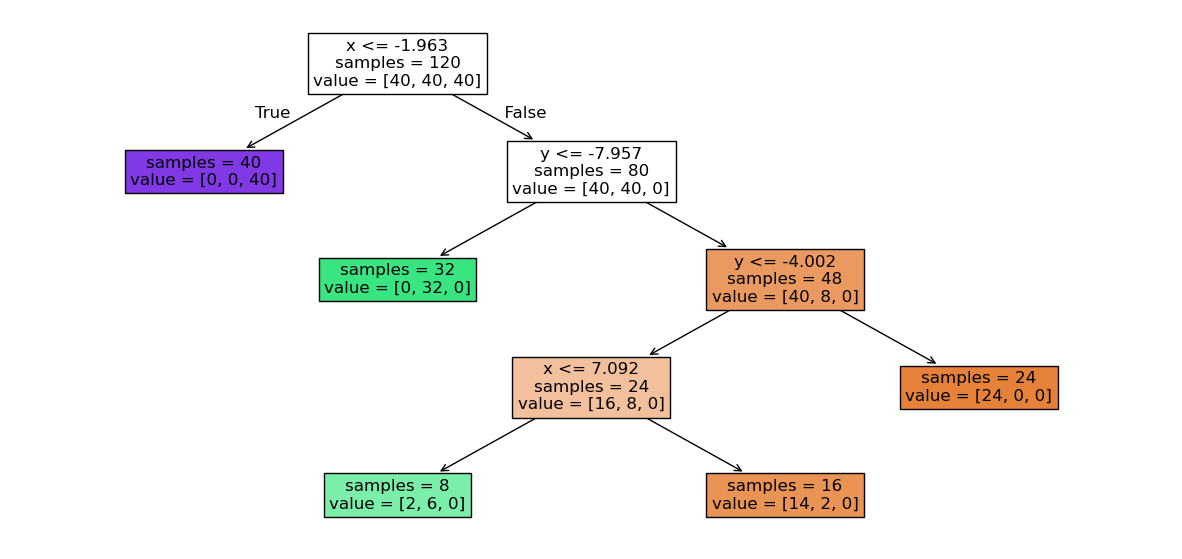

In [97]:
contour_tree(X_3, y_3, crit="entropy", maxd=None, min_s=20, min_l=1, max_f=None)
# Here it is the same as before but this time it applies to nodes instead of leaves
# This parameter is called min_samples_split and is set to 20 here.

There are 3 main advantages to this kind of methods:
* it works with all types of feature
* you don't need to rescale
* it already includes non linear fitting

**Moreover it is 'easy' to interpret.**

But....(yes there is a but, there is no free lunch)

Even with all of those hyperparamaters **they are still not great on new data (inaccuracy...).** 

We will see that in the real data example below and we will see more powerful technics based on decision tree that are more costly but generalize better.

[Back to the ToC](#toc)

### Single decision tree pipeline. <a class="anchor" id="single-tree-pipeline"></a>

In [98]:
## the different hyper parameters on the decision tree are quite related to the dataset size,
##  both in number of columns (for max depth)
##  and in number of rows (for min sample split and min sample leaf)

X_train_cancer.shape

(426, 10)

In [99]:
%%time
from sklearn.tree import DecisionTreeClassifier

grid_values = {
    "criterion": ["entropy", "gini"],
    "max_depth": np.arange(2, X_train_cancer.shape[1] * 2),
    "min_samples_split": np.arange(2, X_train_cancer.shape[0] // 2, 20),
    "min_samples_leaf": np.arange(1, X_train_cancer.shape[0] // 5, 10),
}

grid_tree_cancer = GridSearchCV(
    DecisionTreeClassifier(class_weight="balanced"),
    param_grid=grid_values,
    scoring="accuracy",
    n_jobs=-1,
)
grid_tree_cancer.fit(X_train_cancer, y_train_cancer)

print("Grid best parameter (max. accuracy): ", grid_tree_cancer.best_params_)
print("Grid best score (accuracy): ", grid_tree_cancer.best_score_)

Grid best parameter (max. accuracy):  {'criterion': 'entropy', 'max_depth': 8, 'min_samples_leaf': 11, 'min_samples_split': 2}
Grid best score (accuracy):  0.9412859097127223
CPU times: user 9.59 s, sys: 803 ms, total: 10.4 s
Wall time: 9.93 s


/nfs/cds-peta/exports/biol_micro_cds_gr_sunagawa/scratch/vbezshapkin/conda-envs/data-analysis/lib/python3.11/site-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Grid best parameter (max. accuracy) model on test:  0.9230769230769231


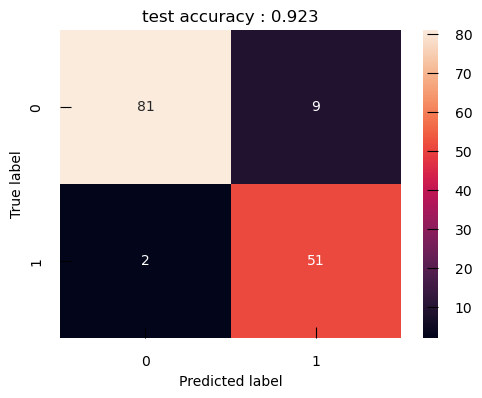

In [100]:
y_cancer_test_score = grid_tree_cancer.score(X_test_cancer, y_test_cancer)

print("Grid best parameter (max. accuracy) model on test: ", y_cancer_test_score)

y_cancer_pred_test = grid_tree_cancer.predict(X_test_cancer)

confusion_m_cancer_tree = confusion_matrix(y_test_cancer, y_cancer_pred_test)
plt.figure(figsize=(5.5, 4))
sns.heatmap(confusion_m_cancer_tree, annot=True)
plt.title("test {} : {:.3f}".format(grid_tree_cancer.scoring, y_cancer_test_score))
plt.ylabel("True label")
plt.xlabel("Predicted label");

Feature importance can be retrieved from the tree: 

In [101]:
w_tree = grid_tree_cancer.best_estimator_.feature_importances_

sorted_features = sorted(
    [[breast_cancer_df.columns[i], abs(w_tree[i])] for i in range(len(w_tree))],
    key=itemgetter(1),
    reverse=True,
)

print("Features sorted per importance in discriminative process")
for f, w in sorted_features:
    print("{:>25}\t{:.3f}".format(f, w))

Features sorted per importance in discriminative process
      mean concave points	0.741
                mean area	0.093
           mean perimeter	0.062
             mean texture	0.054
           mean concavity	0.020
          mean smoothness	0.018
   mean fractal dimension	0.011
         mean compactness	0.000
              mean radius	0.000
            mean symmetry	0.000


And we can even plot the model:

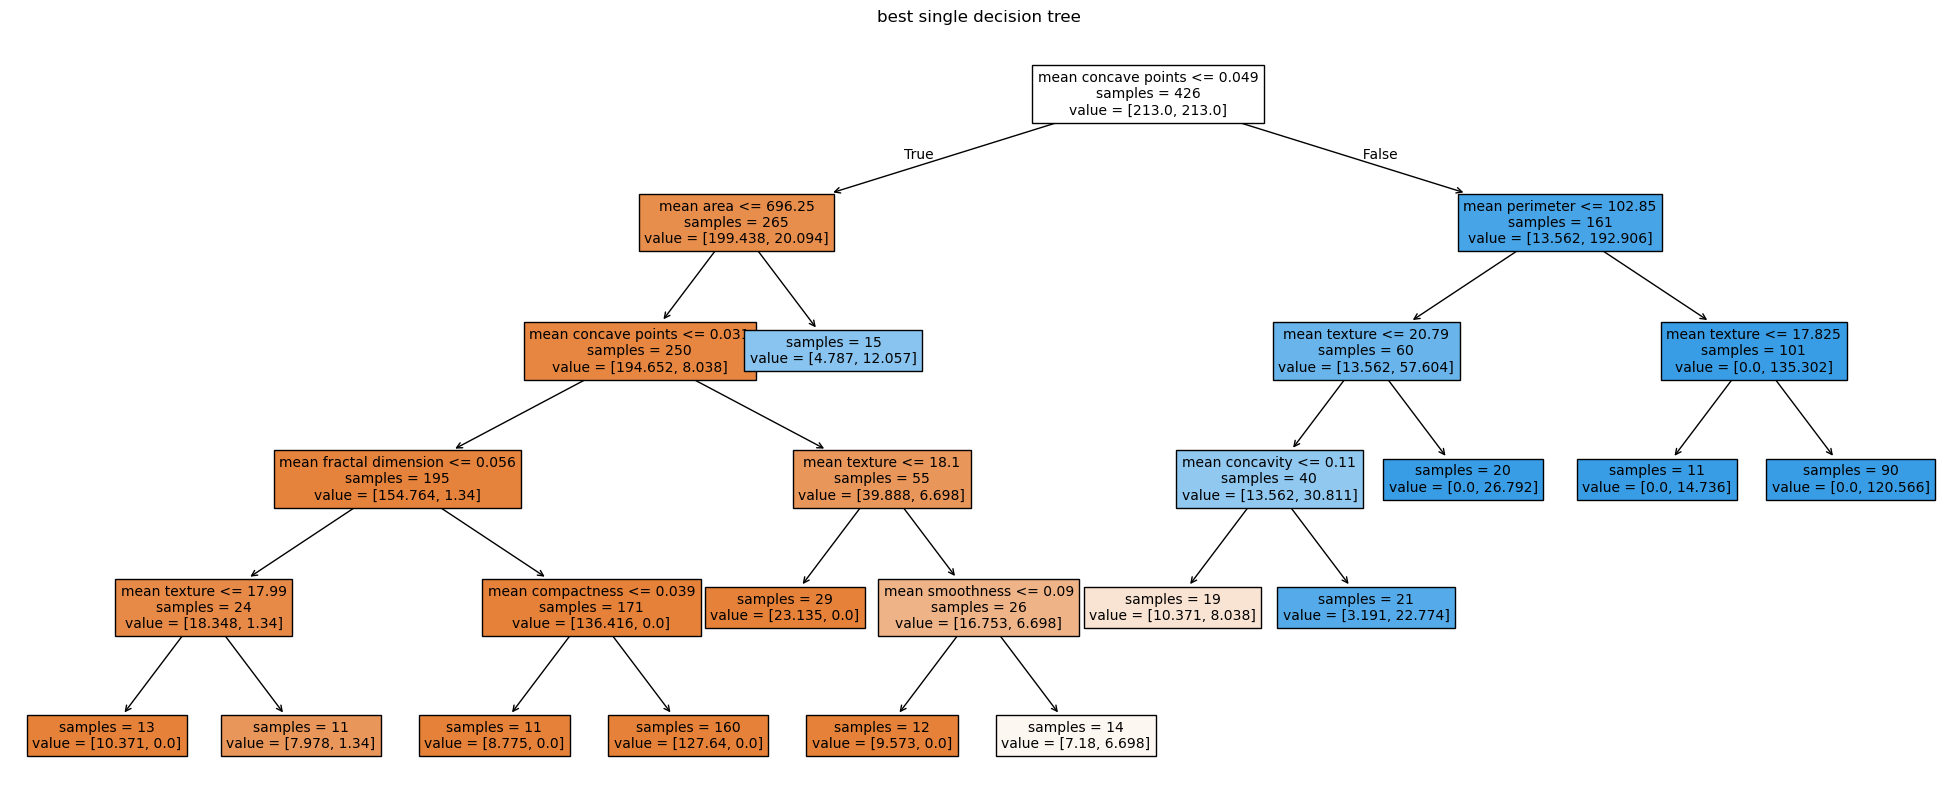

In [102]:
from sklearn.tree import plot_tree

fig, ax = plt.subplots(figsize=(25, 10))
plot_tree(
    grid_tree_cancer.best_estimator_,
    feature_names=breast_cancer_df.columns,
    ax=ax,
    fontsize=10,
    filled=True,
    impurity=False,
    precision=3,
)
ax.set_title("best single decision tree");

<br>

[Back to the ToC](#toc)

<br>

## Random Forest in classification. <a class="anchor" id="rf-c"></a>

the Random Forest algorithm relies on two main concepts : 
1. **randomly producing/training many different trees**
2. **agglomerating the predictions** of all these trees (mainly averaging)


The randomness between trees concerns:
* **[bootstrapping](https://en.wikipedia.org/wiki/Bootstrapping_(statistics)) of the training dataset**
* using only a **random subset of features**


**Bootstrapping:** sampling methods in which you randomly draw a subsample from your data, *with replacement*. The created replicate is the same size as the original distribution.

I am sure you can see intuitively how that is going to help generalization of our model.

So now on top of all the parameters seen before to create each individual trees of the forest, you also have a parameter controlling the number of trees in your forest.

![RF](image/RF.png)
**In the following plots I am plotting the result for a random forest algorithm and compare it to a single decision tree sharing the same hyperparameters value than the one used in the random forest**.




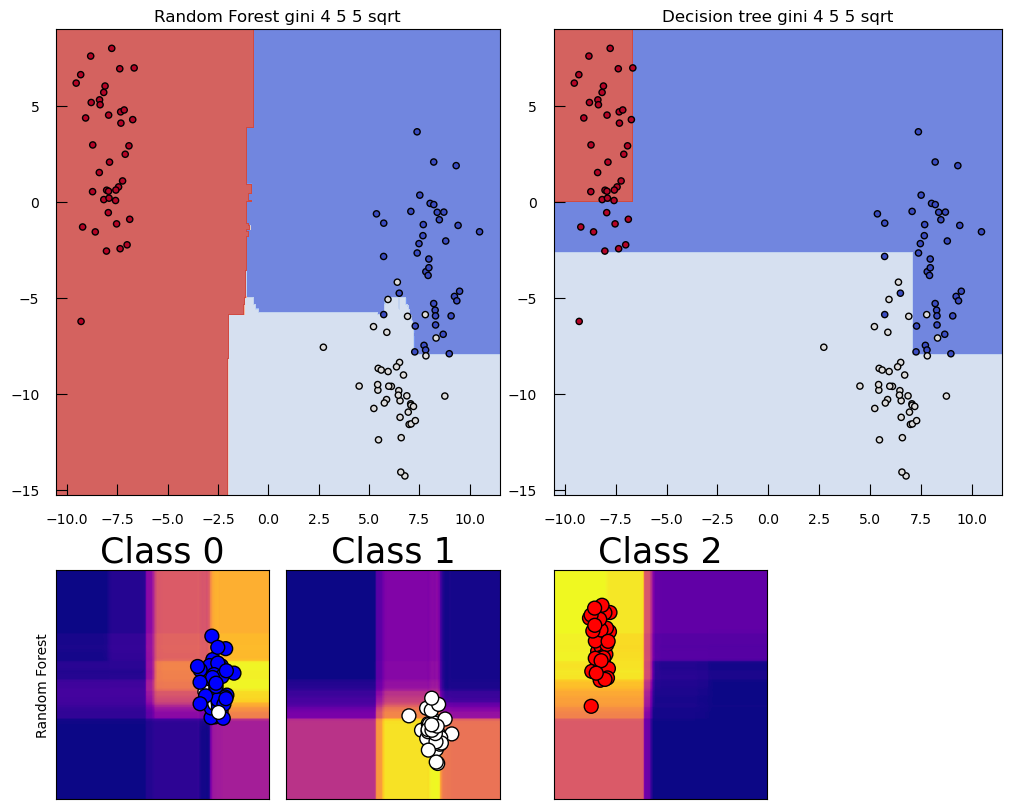

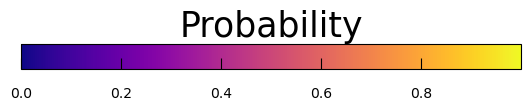

In [103]:
from utils import contour_RF

contour_RF(X_3, y_3, n_tree=200, crit="gini", maxd=4, min_s=5, min_l=5, max_f="sqrt")
# Same as for decision tree except that we have here one more hyperparameter, here
# put to 100 and that represents the number of bootstraps
# (number of trees trained and then participating to the vote)

# also, we restrict the number of variables given to each tree to
# the square root of the original number of variables ->  max_f = 'sqrt'

In [104]:
%%time
from sklearn.ensemble import RandomForestClassifier

##### Now we use RandomForestClassifier
grid_values = {
    "criterion": ["entropy", "gini"],
    "n_estimators": [250, 500],
    "max_depth": np.arange(2, X_train_cancer.shape[1], 2),
    "min_samples_split": [4, 8, 16],
    "min_samples_leaf": [2, 4, 8],
}

grid_RF_cancer = GridSearchCV(
    RandomForestClassifier(class_weight="balanced"),
    param_grid=grid_values,
    scoring="accuracy",
    cv=5,
    n_jobs=-1,
)

grid_RF_cancer.fit(X_train_cancer, y_train_cancer)

print("Grid best score (" + grid_RF_cancer.scoring + "): ", grid_RF_cancer.best_score_)
print(
    "Grid best parameter (max. " + grid_RF_cancer.scoring + "): ",
    grid_RF_cancer.best_params_,
)

/nfs/cds-peta/exports/biol_micro_cds_gr_sunagawa/scratch/vbezshapkin/conda-envs/data-analysis/lib/python3.11/site-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Grid best score (accuracy):  0.9389876880984952
Grid best parameter (max. accuracy):  {'criterion': 'entropy', 'max_depth': 4, 'min_samples_leaf': 8, 'min_samples_split': 16, 'n_estimators': 500}
CPU times: user 2.13 s, sys: 271 ms, total: 2.4 s
Wall time: 7.63 s


In [105]:
y_test_cancer_score = grid_RF_cancer.score(X_test_cancer, y_test_cancer)

print(
    "Grid best parameter (max. " + grid_RF_cancer.scoring + ") model on test: ",
    y_test_cancer_score,
)

Grid best parameter (max. accuracy) model on test:  0.9230769230769231


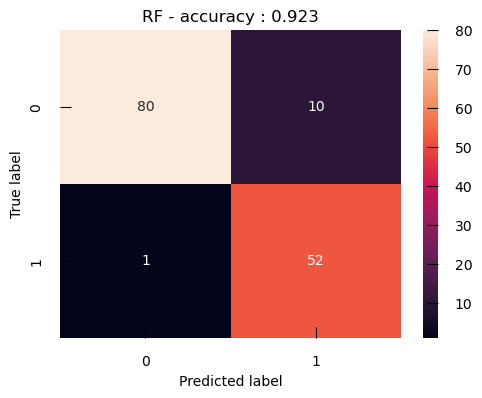

In [106]:
y_pred_test_RF_cancer = grid_RF_cancer.predict(X_test_cancer)

confusion_m_RF_cancer = confusion_matrix(y_test_cancer, y_pred_test_RF_cancer)

plt.figure(figsize=(5.5, 4))
sns.heatmap(confusion_m_RF_cancer, annot=True)
plt.title("RF - {} : {:.3f}".format(grid_RF_cancer.scoring, y_test_cancer_score))
plt.ylabel("True label")
plt.xlabel("Predicted label");

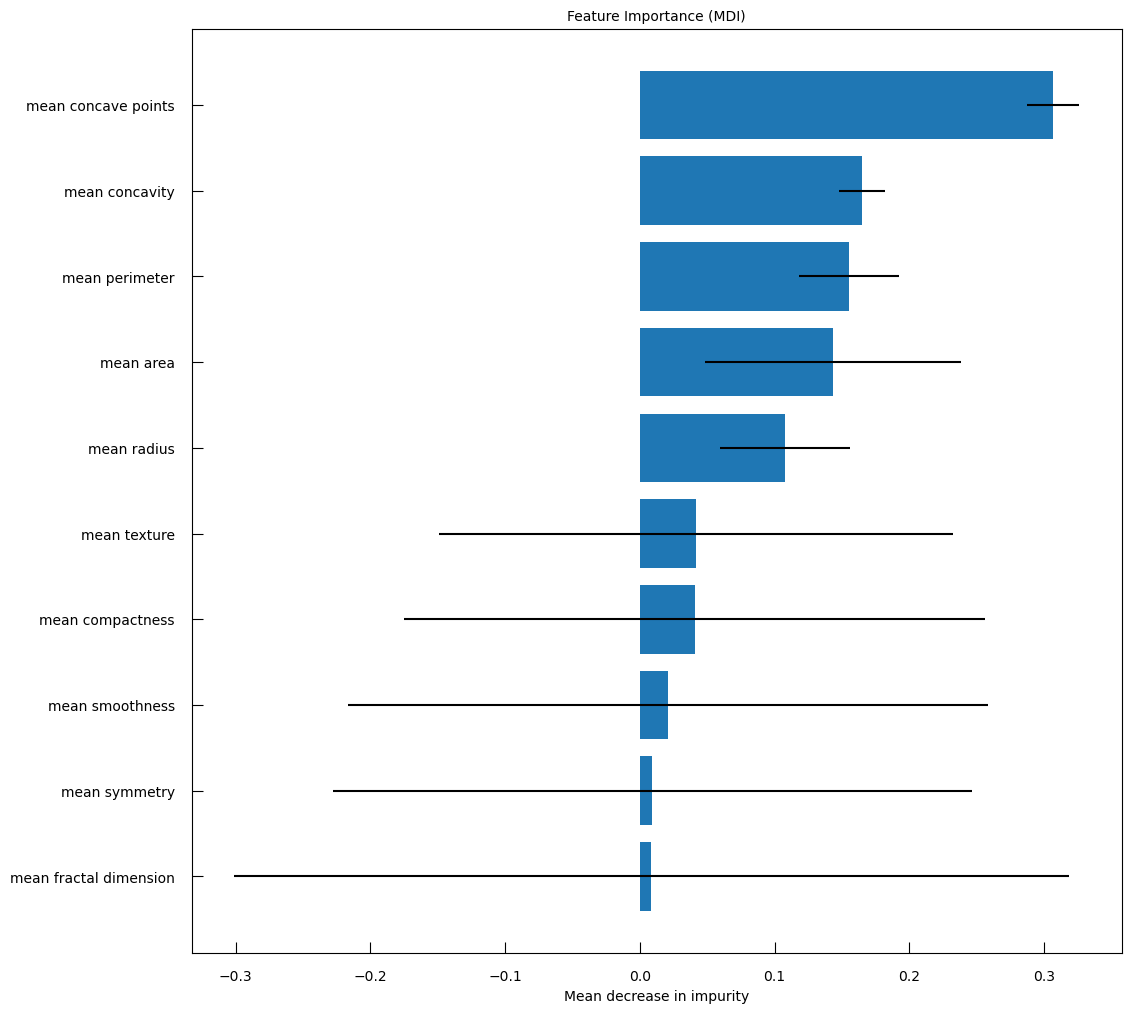

In [107]:
feature_importance_RF_cancer = grid_RF_cancer.best_estimator_.feature_importances_

## by gathering the importance accross each individual tree, we can access
## the standard deviation of this importance
std_RF_cancer = np.std(
    [tree.feature_importances_ for tree in grid_RF_cancer.best_estimator_.estimators_],
    axis=0,
)

sorted_idx = np.argsort(feature_importance_RF_cancer)
pos = np.arange(sorted_idx.shape[0]) + 0.5
fig = plt.figure(figsize=(12, 12))


plt.barh(
    pos,
    feature_importance_RF_cancer[sorted_idx],
    xerr=std_RF_cancer[sorted_idx][::-1],
    align="center",
)
plt.yticks(pos, np.array(list(breast_cancer_df.columns))[sorted_idx])
plt.title("Feature Importance (MDI)", fontsize=10)
plt.xlabel("Mean decrease in impurity")
plt.show()

<br>

[Back to the ToC](#toc)

<br>

## Random Forest in regression. <a class="anchor" id="rf-r"></a>

From the standpoint of tree, the only difference is that now, instead of the entropy or Gini criterion, **the decision which variable to use at any node is made using a regression metric**, such as squared error for example.

For example, consider this example of [regression with a single tree](https://scikit-learn.org/stable/auto_examples/tree/plot_tree_regression.html), adapted from the sklearn website:

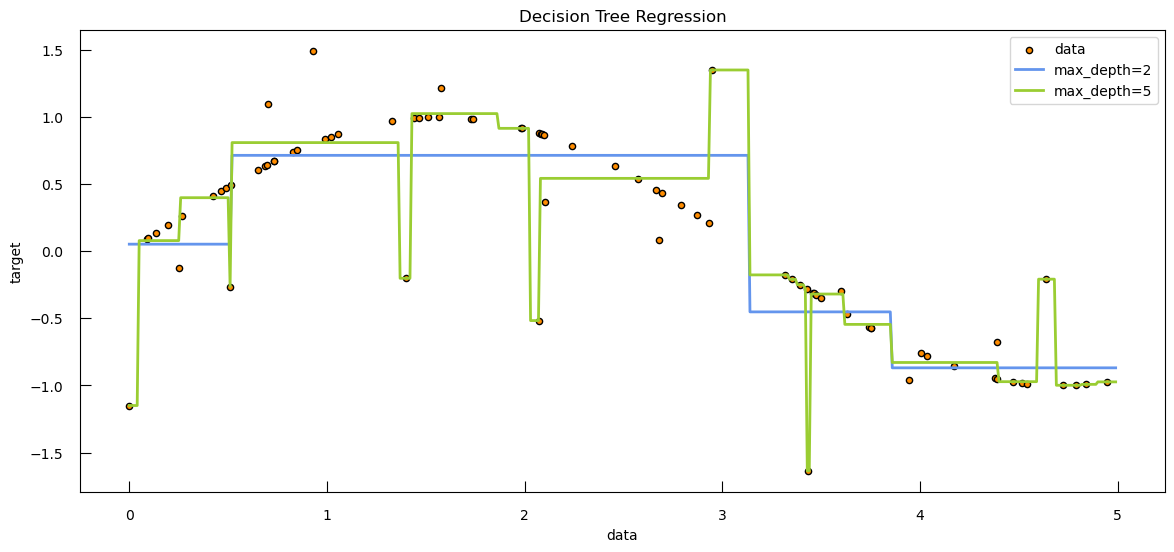

In [108]:
from sklearn.tree import DecisionTreeRegressor

# Create a random dataset
rng = np.random.RandomState(1)
X = np.sort(5 * rng.rand(80, 1), axis=0)
y = np.sin(X).ravel()
y[::5] += 3 * (0.5 - rng.rand(16))  # adding additional noise to some of the points

# Fit regression model
regr_1 = DecisionTreeRegressor(max_depth=2)
regr_2 = DecisionTreeRegressor(max_depth=5)
regr_1.fit(X, y)
regr_2.fit(X, y)

# Predict
X_test = np.arange(0.0, 5.0, 0.01)[:, np.newaxis]
y_1 = regr_1.predict(X_test)
y_2 = regr_2.predict(X_test)

# Plot the results
plt.figure(figsize=(14, 6))
plt.scatter(X, y, s=20, edgecolor="black", c="darkorange", label="data")
plt.plot(X_test, y_1, color="cornflowerblue", label="max_depth=2", linewidth=2)
plt.plot(X_test, y_2, color="yellowgreen", label="max_depth=5", linewidth=2)
plt.xlabel("data")
plt.ylabel("target")
plt.title("Decision Tree Regression")
plt.legend()
plt.show()

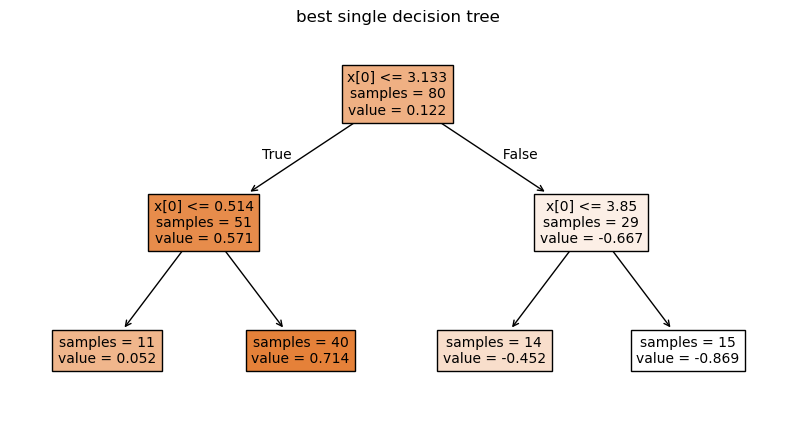

In [109]:
fig, ax = plt.subplots(figsize=(10, 5))
plot_tree(regr_1, ax=ax, fontsize=10, filled=True, impurity=False, precision=3)
ax.set_title("best single decision tree");

Of course with a single tree you do not get very far, unless the tree becomes absolutely huge. 

But with a random forest you can aggregate the estimate from many trees to get somewhere nice.

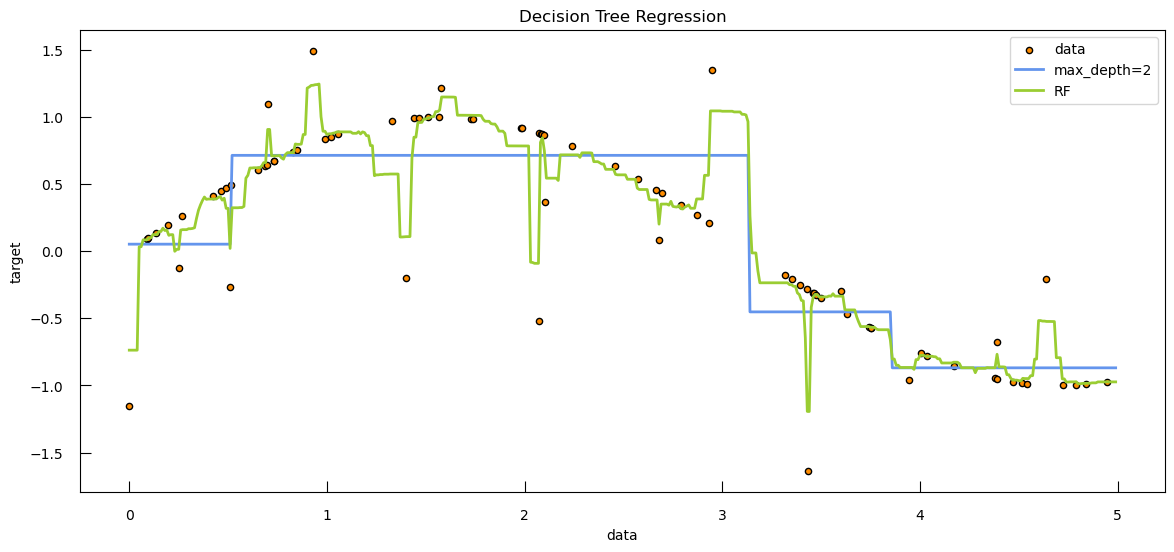

In [110]:
from sklearn.ensemble import RandomForestRegressor

RFReg = RandomForestRegressor(n_estimators=100)
RFReg.fit(X, y)

# Predict
X_test = np.arange(0.0, 5.0, 0.01)[:, np.newaxis]
y_1 = regr_1.predict(X_test)
y_rf = RFReg.predict(X_test)

# Plot the results
plt.figure(figsize=(14, 6))
plt.scatter(X, y, s=20, edgecolor="black", c="darkorange", label="data")
plt.plot(X_test, y_1, color="cornflowerblue", label="max_depth=2", linewidth=2)
plt.plot(X_test, y_rf, color="yellowgreen", label="RF", linewidth=2)
plt.xlabel("data")
plt.ylabel("target")
plt.title("Decision Tree Regression")
plt.legend()
plt.show()

With a bit of leg-work, we can even grab the inidividual trees predictions to build an interval around the random forest prediction: 

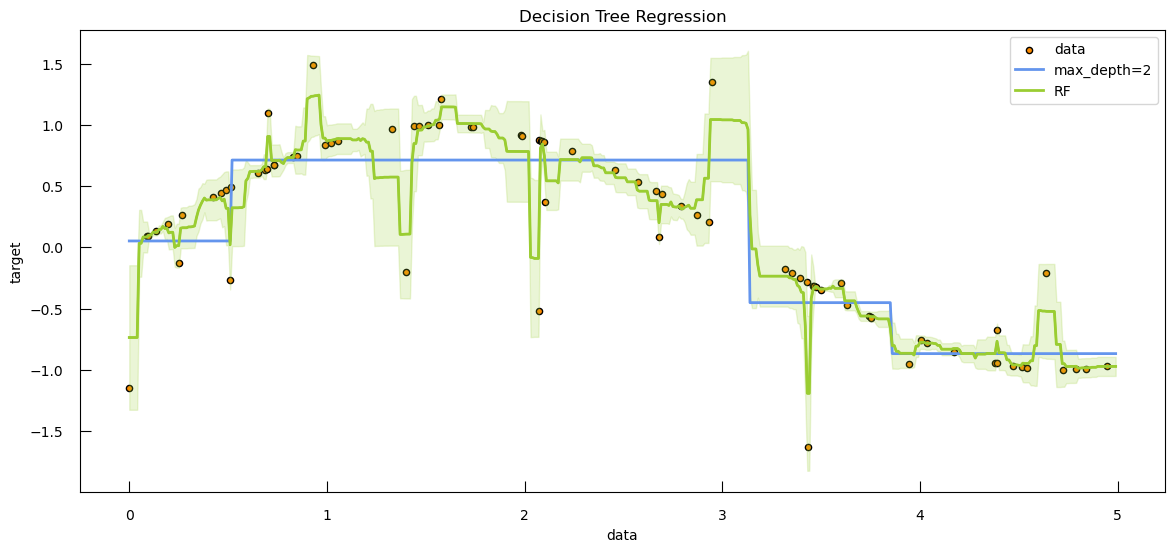

In [111]:
## collecting prediction from all individual trees in a big list
y_pred = []
x_pred = []
for tree in RFReg.estimators_:
    y_pred += list(tree.predict(X_test))
    x_pred += list(X_test[:, 0])


plt.figure(figsize=(14, 6))
plt.scatter(X, y, s=20, edgecolor="black", c="darkorange", label="data")
plt.plot(X_test, y_1, color="cornflowerblue", label="max_depth=2", linewidth=2)
plt.plot(X_test, y_rf, color="yellowgreen", label="RF", linewidth=2)
sns.lineplot(x=x_pred, y=y_pred, color="yellowgreen", errorbar="sd")
plt.xlabel("data")
plt.ylabel("target")
plt.title("Decision Tree Regression")
plt.legend()
plt.show()

Let's try on the diabetes data:

In [112]:
X_diabetes_train.shape

(331, 10)

In [113]:
%%time
from sklearn.ensemble import RandomForestRegressor

## when it comes to criterion, we can now choose:
# * “squared_error” (default) for the mean squared error, minimizes the L2 loss
#                                           using the mean of each terminal node,
# * “friedman_mse”, which uses mean squared error with Friedman’s improvement score for potential splits
# * “absolute_error” for the mean absolute error, which minimizes the L1 loss
#                                           using the median of each terminal node,
# * “poisson” which uses reduction in Poisson deviance to find splits.
#
# let's try squared error and absolute error

grid_values = {
    "criterion": ["squared_error", "absolute_error"],
    "n_estimators": [500],
    "max_depth": [2, 4, 8],
    "min_samples_split": np.arange(2, len(X_diabetes_train) // 5, 20),
    "min_samples_leaf": np.arange(2, len(X_diabetes_train) // 5, 20),
}

grid_RF_diabetes = GridSearchCV(
    RandomForestRegressor(), param_grid=grid_values, scoring="r2", n_jobs=-1, cv=3
)

grid_RF_diabetes.fit(X_diabetes_train, y_diabetes_train)


print("Grid best score (r2): ", grid_RF_diabetes.best_score_)
print("Grid best parameter (max. r2): ", grid_RF_diabetes.best_params_)

Grid best score (r2):  0.48427402455129753
Grid best parameter (max. r2):  {'criterion': 'absolute_error', 'max_depth': 8, 'min_samples_leaf': 2, 'min_samples_split': 22, 'n_estimators': 500}
CPU times: user 2.93 s, sys: 88.4 ms, total: 3.02 s
Wall time: 6.85 s


In [114]:
y_decision_fn_scores_RF_diabetes = grid_RF_diabetes.score(
    X_diabetes_test, y_diabetes_test
)
print("Grid best parameter (max. r2) model on test: ", y_decision_fn_scores_RF_diabetes)

Grid best parameter (max. r2) model on test:  0.4416711085156


In [115]:
feature_importance_diabetes = grid_RF_diabetes.best_estimator_.feature_importances_

sorted_features = sorted(
    [
        [df_diabetes.columns[i], abs(feature_importance_diabetes[i])]
        for i in range(len(feature_importance_diabetes))
    ],
    key=itemgetter(1),
    reverse=True,
)

print("Features sorted per importance in discriminative process")
for f, w in sorted_features:
    print("{:>20}\t{:.3f}".format(f, w))

Features sorted per importance in discriminative process
                  s5	0.363
                 bmi	0.290
                  bp	0.089
                  s3	0.058
                 age	0.049
                  s6	0.044
                  s2	0.037
                  s1	0.035
                  s4	0.030
                 sex	0.004


Tree-based techniques are interesting because:
 * they do not necessitate scaling
 * they give interpretable models and results
 * they model arbitrary non-linear problems
 
However as you have seen they tend to take longer to train...

[back to the ToC](#toc)
    
# Conclusion <a id='conclusion'></a>

During this notebook we have only given a whirlwind tour of what ML is and what is it about.

We have of course only mentionned a handful of the numerous algorithms that can be used, both for [classification and for regression](https://scikit-learn.org/stable/supervised_learning.html) (NB: this link is not an exhaustive list, just what has been implemented in the sklearn library).

However, more than a collection of algorithm, Machine Learning should also be seen as a set of methods to solve some important statistical problems :
 * **regularization** parameters (such as l1 or l2 norm, or max depth), to handle **overfitting**
 * **cross-validation** strategies, to detect **overfitting** and handle **model-selection**
 * **adapted metrics** to handle the specific of our goal and our data (handle imbalance for example).
   * [classification metrics](https://scikit-learn.org/stable/modules/model_evaluation.html#classification-metrics)
   * [regression metrics](https://scikit-learn.org/stable/modules/model_evaluation.html#regression-metrics)

<br>

[Back to the ToC](#toc)

<br>

# Classification exercise : predicting heart disease on the framingham data-set <a class="anchor" id="exo-classif"></a>

Use everything you have learned to model and predict the column `'TenYearCHD'` (dependent variable : ten year risk of coronary heart disease).

In [116]:
##separation in X and y
X_heart = df_heart.drop(columns="TenYearCHD")
y_heart = df_heart["TenYearCHD"]

In [117]:
X_heart.head()

male  age  education  currentSmoker  cigsPerDay  BPMeds  prevalentStroke  \
0     1   39        4.0              0         0.0     0.0                0   
1     0   46        2.0              0         0.0     0.0                0   
2     1   48        1.0              1        20.0     0.0                0   
3     0   61        3.0              1        30.0     0.0                0   
4     0   46        3.0              1        23.0     0.0                0   

   prevalentHyp  diabetes  totChol  sysBP  diaBP    BMI  heartRate  glucose  
0             0         0    195.0  106.0   70.0  26.97       80.0     77.0  
1             0         0    250.0  121.0   81.0  28.73       95.0     76.0  
2             0         0    245.0  127.5   80.0  25.34       75.0     70.0  
3             1         0    225.0  150.0   95.0  28.58       65.0    103.0  
4             0         0    285.0  130.0   84.0  23.10       85.0     85.0

Splitting in train/test set

In [118]:
# %load -r -7 solutions/solution_03_03.py
X_train_heart, X_test_heart, y_train_heart, y_test_heart = train_test_split(
    X_heart, y_heart, random_state=123456, stratify=y_heart
)
# stratify is here to make sure that you split keeping the repartition of labels unaffected

print("fraction of class benign in train", sum(y_train_heart) / len(y_train_heart))
print("fraction of class benign in test ", sum(y_test_heart) / len(y_test_heart))
print("fraction of class benign in full ", sum(y_heart) / len(y_heart))

fraction of class benign in train 0.15238789646372586
fraction of class benign in test  0.15191256830601094
fraction of class benign in full  0.15226899945325315


Logistic regression

In [119]:
# %load -r 9-33 solutions/solution_03_03.py

SVM

In [120]:
# %load -r 34-47 solutions/solution_03_03.py

random forest

In [121]:
# %load -r 48-65 solutions/solution_03_03.py

Evaluation of the best model on the test set

In [122]:
# %load -r 67-90 solutions/solution_03_03.py

ROC curve

In [123]:
# %load -r 93-116 solutions/solution_03_03.py

getting the most important features

In [124]:
# %load -r 119-145 solutions/solution_03_03.py

Additionnal little diagnostic plot

In [125]:
# %load -r 146- solutions/solution_03_03.py

<br>

[Back to the ToC](#toc)

<br>

# Additionnal Regression exercise : predicting daily maximal temperature <a class="anchor" id="exo-regression"></a>

In [126]:
features = pd.read_csv("data/One_hot_temp.csv")
features.head(5)

Unnamed: 0  year  month  day  temp_2  temp_1  average  actual  \
0           0  2016      1    1      45      45     45.6      45   
1           1  2016      1    2      44      45     45.7      44   
2           2  2016      1    3      45      44     45.8      41   
3           3  2016      1    4      44      41     45.9      40   
4           4  2016      1    5      41      40     46.0      44   

   forecast_noaa  forecast_acc  forecast_under  friend  week_Fri  week_Mon  \
0             43            50              44      29         1         0   
1             41            50              44      61         0         0   
2             43            46              47      56         0         0   
3             44            48              46      53         0         1   
4             46            46              46      41         0         0   

   week_Sat  week_Sun  week_Thurs  week_Tues  week_Wed  
0         0         0           0          0         0  
1         1         0           0          0         0  
2         0         1           0          0         0  
3         0         0           0          0         0  
4         0         0           0          1         0


 * year: 2016 for all data points
 * month: number for month of the year
 * day: number for day of the year
 * week: day of the week as a character string
 * temp_2: max temperature 2 days prior
 * temp_1: max temperature 1 day prior
 * average: historical average max temperature
 * actual: max temperature measurement
 * friend: your friend’s prediction, a random number between 20 below the average and 20 above the average
 

Additionally, all the features noted forecast are weather forecast given by some organisation for that day.


We want to predict `actual`, th actual max temperature of a day.

Use a random forest to do so. You can inspire yourself from the examples of code above.

Here are a couple of plots to get you started with the data exploration:

ValueError: rotation must be 'vertical', 'horizontal' or a number, not 60

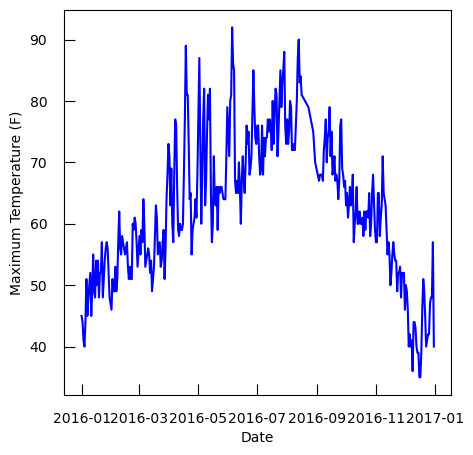

In [127]:
import datetime

feature_list = list(features.columns)
labels = features["actual"]
# Dates of training values
months = np.array(features)[:, feature_list.index("month")]
days = np.array(features)[:, feature_list.index("day")]
years = np.array(features)[:, feature_list.index("year")]

# List and then convert to datetime object
dates = [
    str(int(year)) + "-" + str(int(month)) + "-" + str(int(day))
    for year, month, day in zip(years, months, days)
]
dates = [datetime.datetime.strptime(date, "%Y-%m-%d") for date in dates]

# Dataframe with true values and dates
true_data = pd.DataFrame(data={"date": dates, "actual": labels})


plt.xlabel("Date")
plt.ylabel("Maximum Temperature (F)")

# Plot the actual values
plt.plot(true_data["date"], true_data["actual"], "b-", label="actual")
plt.xticks(rotation="60")
plt.show()

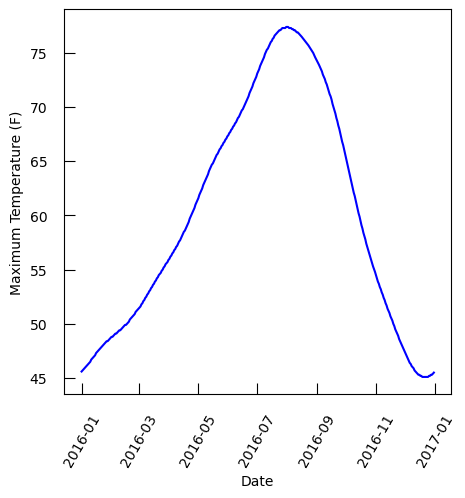

In [ ]:
import datetime

feature_list = list(features.columns)
labels = features["average"]
# Dates of training values
months = np.array(features)[:, feature_list.index("month")]
days = np.array(features)[:, feature_list.index("day")]
years = np.array(features)[:, feature_list.index("year")]

# List and then convert to datetime object
dates = [
    str(int(year)) + "-" + str(int(month)) + "-" + str(int(day))
    for year, month, day in zip(years, months, days)
]
dates = [datetime.datetime.strptime(date, "%Y-%m-%d") for date in dates]

# Dataframe with true values and dates
true_data = pd.DataFrame(data={"date": dates, "average": labels})


plt.xlabel("Date")
plt.ylabel("Maximum Temperature (F)")

# Plot the average values
plt.plot(true_data["date"], true_data["average"], "b-", label="average")
plt.xticks(rotation="60")
plt.show()

Solution - Read in data 

In [128]:
# %load -r 1-5 solutions/solution_03_02.py

Solution - train/test split

In [129]:
# %load -r 8-17 solutions/solution_03_02.py

Solution - setup and fit pipeline

In [130]:
# %load -r 19-34 solutions/solution_03_02.py

Solution - evaluate the model on the test set

In [131]:
# %load -r 36-40 solutions/solution_03_02.py

Solution - get the feature importances 

In [132]:
# %load -r 41-49 solutions/solution_03_02.py

Solution - using permutation to get the importances



In [133]:
# %load -r 50-73 solutions/solution_03_02.py

Solution - BONUS - re-thinking the splitting strategy

![RF](image/TimeSeriesSplit.png)

In [134]:
# %load solutions/solution_03_02ter.py

Solution - BONUS - an even better splitting strategy

![RF](image/BlockedTimeSeriesSplit.png)

In [135]:
# %load solutions/solution_03_02quat.py

<br>

[Back to the ToC](#toc)

<br>

# Annexes <a id='annex'></a>

### Features selection

In [136]:
df = sns.load_dataset("iris")
# Here we use the data loader from seaborn but such data loaders also exist with scikit-learn and are more generally delt
# with the dataframe handler pandas
df.head()

sepal_length  sepal_width  petal_length  petal_width species
0           5.1          3.5           1.4          0.2  setosa
1           4.9          3.0           1.4          0.2  setosa
2           4.7          3.2           1.3          0.2  setosa
3           4.6          3.1           1.5          0.2  setosa
4           5.0          3.6           1.4          0.2  setosa

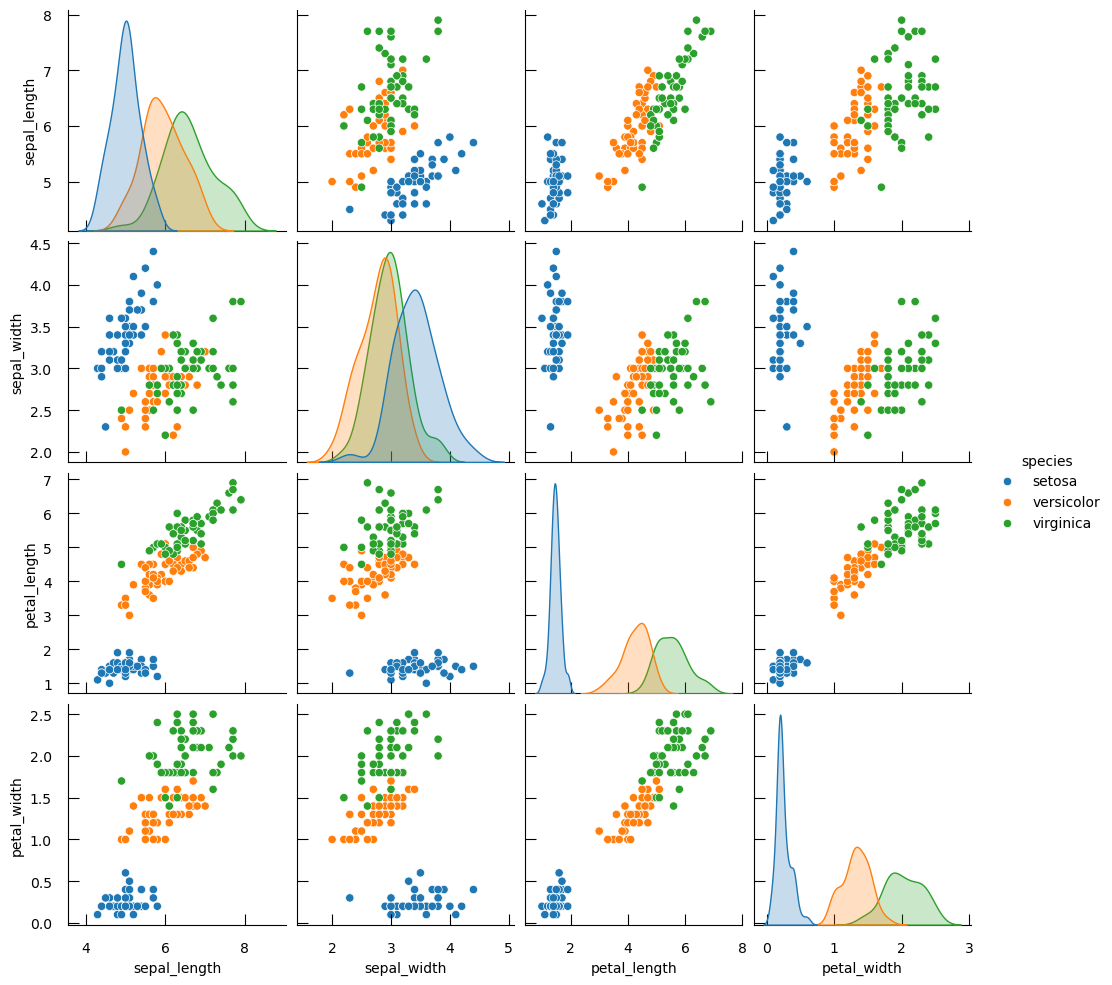

In [137]:
sns.pairplot(df, hue="species")
# Seaborn allows you to 'split' your data according to a chosen parameter hue. Here I chose to color split the data according
# to the target
# description diagonal

What do you get from the plots above?

Looking at the diagonal of these plots : petal features separate the species more efficiently than sepal features.

There is a very strong correlation between `petal_length` and `petal_width` : those two features are probably so similar that keeping them both could be redundant.

The least correlation visible seems to be between `sepal_width` and all the others.

By itself `sepal_width` is not good at differentiating species but associated with other features we can already see groups forming by species. And since they are very much non-colinear I would say that, in dimension two, `petal_length` and `sepal_width` are already a good pick for low dimensions models.

You can actually quantify the correlation between features by calling the `corr()` function in pandas. You would prefer (and sometime is requiered) having a subset of features that are not correlated to each others.

In [138]:
df_corr = df.corr()

sns.clustermap(
    df_corr,
    figsize=(8, 8),
    z_score=None,
    row_cluster=True,
    col_cluster=True,
    method="ward",
    cmap="coolwarm",
    vmax=1,
    vmin=-1,
    annot=True,
    annot_kws={"size": 13},
    cbar_kws={"label": "Pearson\ncorrelation"},
)
## sns allows you to do a hierarchical clustering that simply
plt.show()

ValueError: could not convert string to float: 'setosa'

##### Classification
One thing (among others) that you can do is to look for a **subset of features that seems to be important to describe the target class**. It's like the pairplots above but instead of just looking at it you choose the features you want to keep.

You can choose different metrics for 'how important to describe the class' a feature is. 
Many of those metrics utilize concepts that we haven't introduced yet, in contexts that we haven't seen yet, so I will introduce two metrics for classification that don't need too much of *a priori* knowledge. 

`Scikit-learn` lets you specify a threshold on the features are kept, either as:
* a direct number: `SelectKBest`.
* important features from a percentile of your top importance score: `SelectPercentile`.
* an error type: `SelectFpr` or `SelectFdr` (see course 2 logistic regression part).


`Scikit-learn` offers you different scores to calculate the importance of your features.

* **ANOVA-F** : F=$\frac{Var_{feature\_i}(Between\_class)}{Var_{feature\_i}(Within\_class)}$. 

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;
**F** itself gives you how much a feature $i$ variance is different between classes, normalized by the intrinsic variance of that feature per class. 

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; 
So if **F** is big it means that the variation that you observe between classes is big compared to the variance of this feature : 

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; 
it behaves differently for different classes so it it is a good feature to keep for the classification. 

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; 
To this **F** is associated a **p-value** that you would use for scoring.


* **Chi2** ($\chi^{2}$) test. 

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;
You suppose the null hypothesis that this feature $i$ is homogenously distributed among classes

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;
and so you are expecting that its representation in different classes should be very similar to what you can calculate for the bulk data

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;
 i.e. $\frac{\Sigma^{n\_points} feature_{i}}{n\_points}$.

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;
You then compare the actual distribution of this feature in different classes to your null model predictions. If this **sum of square differences**: 

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;
$\Sigma^{n\_class}_{k}\frac{(expected\_form\_null\_hypothesis_{k}-observed_{k})^{2}}{observed}$

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; 
is big then the null hypothesis has to be rejected and this feature is significant for classifying. 

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;
The sum of these square quantities over the different classes asymptotically follows a $\chi^{2}$ 

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;
distribution and thus you have access to a **p-value for scoring**.


Another score would be to use the amount of [Mutual Information](https://en.wikipedia.org/wiki/Mutual_information) shared between a feature and our target. 

The way this mutual information is caclulated is out of the scope of this class as it is a bit technical.

##### For regression just use correlation or Mutual Iformation

In [ ]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

skb = SelectKBest(
    chi2, k=2
)  # creating the object SelectKBest and settling for 2 best features (k=2) in term of chi2 score
skb.fit(
    df[list(df.columns)[:-1]], df[list(df.columns)[-1]]
)  # calculating the chi2 for each features

dico_pval = {df.columns[i]: v for i, v in enumerate(skb.pvalues_)}
print(
    "features Chi2 scores (p-values):"
)  # all the features and the chi2 pvalues associated. use .pvalues_
for feature, pval in dico_pval.items():
    print("\t", feature, ":", pval)

X_new = skb.transform(
    df[list(df.columns)[:-1]]
)  # keep only the k=2 best features according to the score

print("New data with only the k=2 best features kept :")
print(X_new[:5,])  # printing only the 5 first entries
print("...")

features Chi2 scores (p-values):
	 sepal_length : 0.004476514990225755
	 sepal_width : 0.15639598043162506
	 petal_length : 5.533972277193705e-26
	 petal_width : 2.7582496530033412e-15
New data with only the k=2 best features kept :
[[1.4 0.2]
 [1.4 0.2]
 [1.3 0.2]
 [1.5 0.2]
 [1.4 0.2]]
...


### Multi classes

In [ ]:
X3, y3 = make_blobs(
    n_samples=120, centers=3, cluster_std=3, random_state=6
)  # 120 points, 3 blobs/clusters with some spread=3
# Random_state is here just to be sure that every time you will get the same blobs. If you change the random_state or do not
# specify it then you will get a new plot every time you call the function (random seed)

Of course all of that can be applied to a multi-classes classification. How is it tipically done?

There are many different ways of tackling the problem, that end up being a combination of these 4 elements :

- **Either you treat the problem as one class vs one class**.

- **Or you treat the problem as a one class vs the rest : you subdivide the problem into three different problems either your are class 1 and you consider the other classes as being one big class "non 1", and you do the same for the other class**.
- **You change your loss function to a multinomial one : softmax intead of a sigmoid.** 

In any case you need to decide **how you are going to agglomerate those different statistics (different ROC curves for example)**:

- **micro average** : pull all raw numbers together (eg. number of FP, TP), group them and then calculate your overall statistic (eg. TPR)
- **macro average** : calculate each statistics separately and then do the average.

Think about the differences induced by those metrics. Why should you use one more than the other? Or maybe you should always use all of them?

Spoiler it has to do with overall separability and balance between the different class.


What strategy your logistic regression uses so you can plot the right curves, is a tricky question. For a first pass on your data always set the multiclasses method to be ovr (one vs rest) : understanding the hyperplanes relation to decision probability and the ROC curve is more intuitive that way, and I believe less sensitive to imbalance dataset.

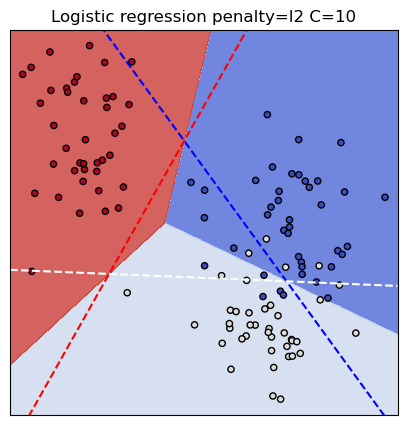

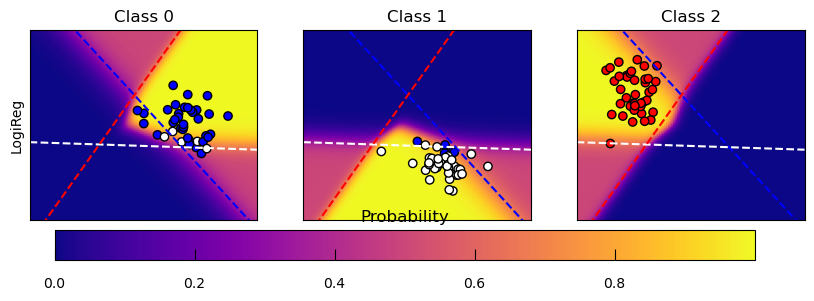

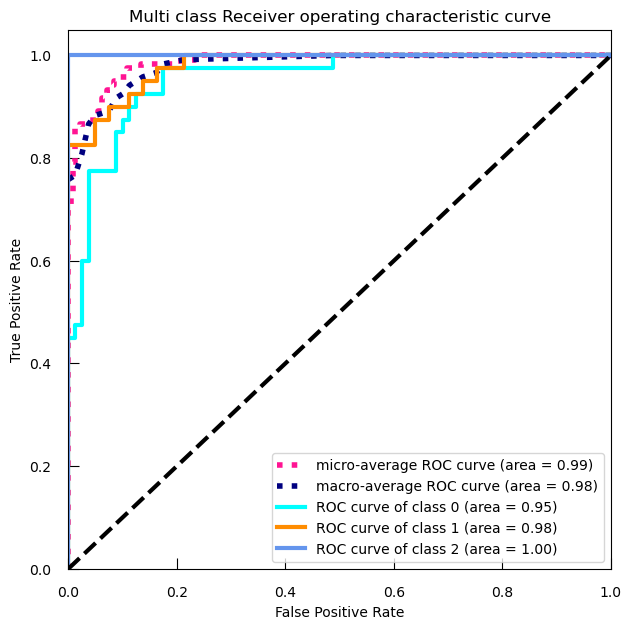

In [ ]:
from utils import contour_lr_more

# one vs rest implementation
contour_lr_more("l2", X3, y3, 10, "ovr")


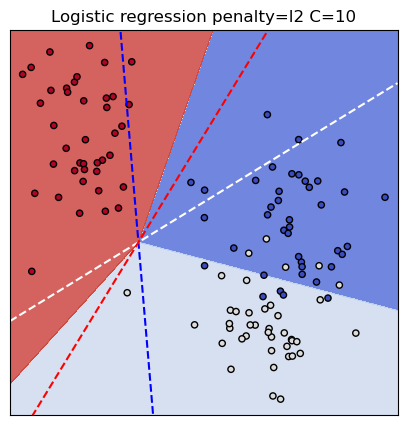

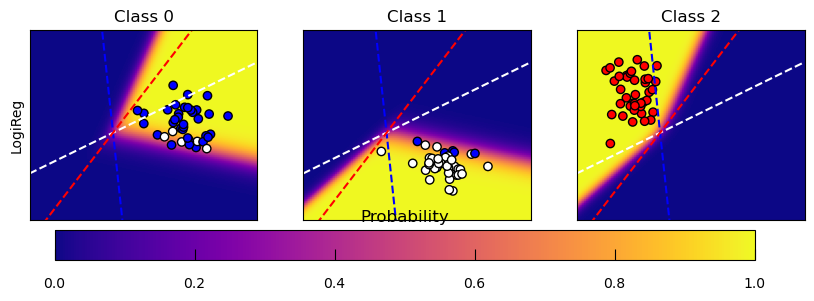

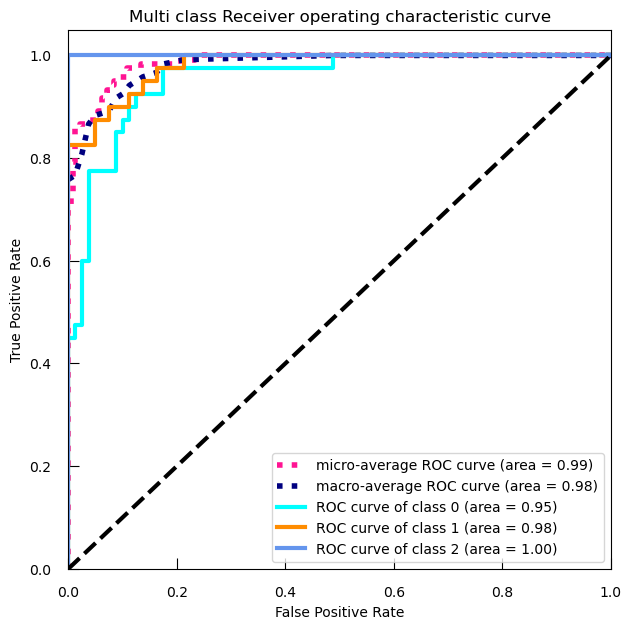

In [ ]:
from utils import contour_lr_more

# softmax implementation (something only available with logistic regression), and again different from one vs one
# and one vs rest
contour_lr_more("l2", X3, y3, 10, "multinomial")
